## Bankruptcy prediction using neural networks and other ML algorithms
This jupyter notebook is a modified version of the project I did during the writing of my Master's thesis called 'Neural netwoks in financial institutions'. My aim was to create a banrkuptcy prediction model using a neural network and consequently compare it with other benchmark ML algorithms used for classification, such as logistic regression, random forests and gradient boosting machines. 

The collected data [(seen here)](https://pubmed.ncbi.nlm.nih.gov/31463350/) has information about ~20 000 small and medium Slovak companies in the manufacture industry. The data holds information about 21 financial ratios for each company that have been calculated from public data, collected over three years before the evaluation period, giving us the final number of 63 predictors. The 64th column is the binary output variable, which indicates whether the given company filed for bankruptcy in the evaluation period.

As is the common case with real world data, it is messy and needs some care before we can use it for training algorithms, especially neural networks. The main problems are outliers, missing values and different orders of magnitude of the predictors; therefore, the use of preprocessing steps such as winsorization, scaling and imputation was needed to clean the data before training.

## Setup 
First, we need to load the data and some modules we will use throughout the whole project. 

In [5]:
# Modules
import pandas as pd 
import numpy as np 
import csv

In [6]:
# Load data 
manu_test = pd.read_csv(r'data_manu_final.csv', sep = ';', decimal = ',')
manu_test = manu_test.drop(columns = ['X'])
manu = manu_test.reset_index(drop = True)
# Split into output variable and predictors
X = manu.drop(columns = ['bankrupt'])
y = manu['bankrupt']

## Exploratory analysis 
EDA, or *exploratory data analysis*, is the first step of analysing data, as we need to take a thorough look at the quality of data we are dealing with. Our main concerns are NA values = missing data, so let us take a look at what proportion of values are missing in each of the financial ratios. 

In [7]:
manu.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V55,V56,V57,V58,V59,V60,V61,V62,V63,bankrupt
0,0.03,0.06,0.07,0.06,0.24,0.49,968.52,84.00,429.42,118.00,...,2.36,5.57,57.56,10.59,0.62,9556.27,5.11,11.43,37.78,0
1,10.68,11.08,12.86,3.52,22.25,26.80,438.14,291.31,15.55,71.61,...,3.16,12.92,68.31,14.46,1.07,18127.50,6.56,6.25,29.41,0
2,6.46,17.93,0.70,1.12,1.12,1.12,39.70,-0.03,8.33,0.00,...,3.58,9.42,72.03,32.39,1.36,NaN,7.75,1.87,30.91,0
3,36.70,55.67,15.58,4.98,6.91,6.91,154.49,27.95,14.46,0.05,...,5.04,58.06,80.15,15.67,0.64,22078.00,3.14,23.78,77.75,0
4,0.12,1.32,0.07,0.18,0.75,1.16,223.90,108.83,142.77,78.80,...,52.11,30.91,98.08,0.03,NaN,7989.63,27.19,19.62,98.89,0


In [8]:
# Proportions of missing values
miss = []
for i in range(manu.shape[1]):
    pocet = manu.iloc[:, i].isna().sum()
    pct = 100 * pocet / manu.shape[0]
    miss.append(pct)
    print('.. %d, Missing Values: %d (%.1f%%)' % (i, pocet, pct))
miss = miss[0:63]

.. 0, Missing Values: 106 (0.5%)
.. 1, Missing Values: 106 (0.5%)
.. 2, Missing Values: 838 (4.3%)
.. 3, Missing Values: 558 (2.9%)
.. 4, Missing Values: 530 (2.7%)
.. 5, Missing Values: 543 (2.8%)
.. 6, Missing Values: 780 (4.0%)
.. 7, Missing Values: 1427 (7.3%)
.. 8, Missing Values: 887 (4.6%)
.. 9, Missing Values: 4104 (21.1%)
.. 10, Missing Values: 425 (2.2%)
.. 11, Missing Values: 422 (2.2%)
.. 12, Missing Values: 106 (0.5%)
.. 13, Missing Values: 106 (0.5%)
.. 14, Missing Values: 133 (0.7%)
.. 15, Missing Values: 521 (2.7%)
.. 16, Missing Values: 3491 (17.9%)
.. 17, Missing Values: 9146 (46.9%)
.. 18, Missing Values: 262 (1.3%)
.. 19, Missing Values: 764 (3.9%)
.. 20, Missing Values: 389 (2.0%)
.. 21, Missing Values: 123 (0.6%)
.. 22, Missing Values: 127 (0.7%)
.. 23, Missing Values: 1277 (6.6%)
.. 24, Missing Values: 326 (1.7%)
.. 25, Missing Values: 295 (1.5%)
.. 26, Missing Values: 301 (1.5%)
.. 27, Missing Values: 482 (2.5%)
.. 28, Missing Values: 1042 (5.3%)
.. 29, Missing 

<AxesSubplot:>

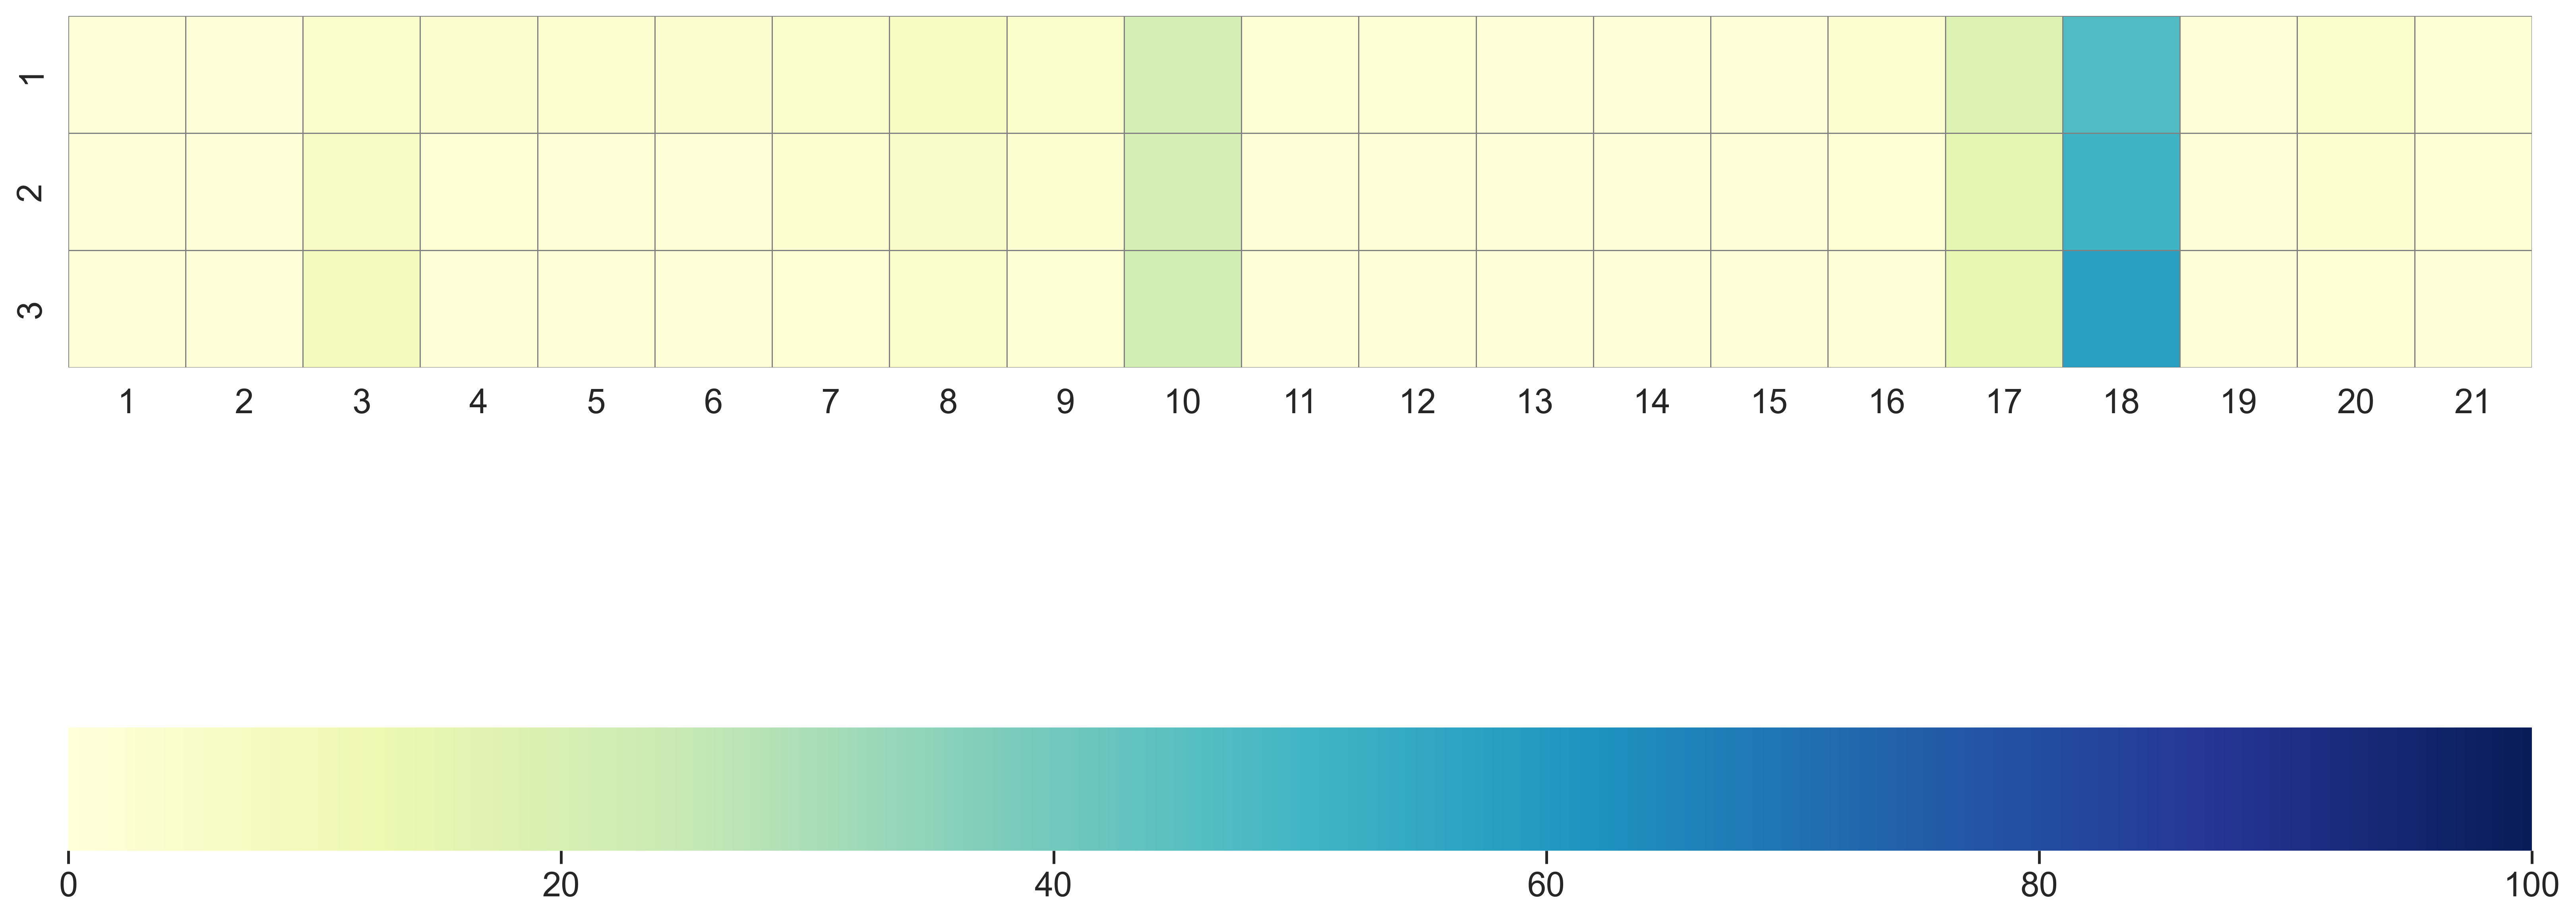

In [10]:
import seaborn as sns
from matplotlib import pyplot as plt
plt.figure(figsize = (20, 20), dpi = 400)
sns.set(font_scale = 1.4)
miss = np.array(miss)
miss.shape = [3, 21]
df = pd.DataFrame(miss, columns = np.arange(21) + 1, index = np.arange(3) + 1)
sns.heatmap(df, vmin = 0, vmax = 100, cmap = "YlGnBu", square = True,  
            cbar_kws={"orientation": "horizontal"}, linewidths = 0.2, linecolor = 'gray')

As we can see, the most of the columns were missing up to 5% of values, some of them reached up to 20% and three of the columns had a much higher number of NA values. Let us identify the columns that had at least 30% of values missing: 

In [11]:
for i in np.arange(X.shape[1]):
    if X.iloc[:,i].isna().sum() / X.shape[0] >= 0.3:
        print('{} missing data:  {:.1f} %.'.format(X.columns[i], X.iloc[:,i].isna().sum() / X.shape[0] * 100))

V18 missing data:  46.9 %.
V39 missing data:  51.2 %.
V60 missing data:  57.5 %.


These columns correspond to the same financial ratio, collected during the three consecutive years. As the proportions of missing data are too high, I decided to completely omit these predictors in my analysis and algorithm training. I created some transformers that will help us with selecting our wanted columns and winsorization in a proper machine learning pipeline, so I will load them now.

In [12]:
# Winsorization function
def winsor_dat(df, alpha):
    q_low = df.quantile(alpha)
    q_hi = df.quantile(1 - alpha)
    out_low = (df < q_low)
    out_hi = (df > q_hi)
    df = df.mask(out_low, q_low, axis = 1)
    df = df.mask(out_hi, q_hi, axis = 1)
    return df

# Winsorization transformer
def winsor_mask(df, qlo, qhi):
    out_low = (df < qlo)
    out_hi = (df > qhi)
    df = df.mask(out_low, qlo, axis = 1)
    df = df.mask(out_hi, qhi, axis = 1)
    return df
    
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
class WinsorTrans(BaseEstimator, TransformerMixin):
    def __init__(self, alpha = 0.05):
        # Initialization
        self.alpha = alpha
        print('\n > init() called.\n')
    
    def fit(self, X, y = None):
        # Fit lower and upper quantiles, as transformer attributes
        self.qlow = X.quantile(self.alpha)
        self.qhi = X.quantile(1 - self.alpha)
        return self 
    
    def transform(self, X, y = None):
        X_cop = X.copy()
        X_cop = winsor_mask(X_cop, self.qlow, self.qhi)
        return X_cop
    
# Column selection transformer
class SelectCols(BaseEstimator, TransformerMixin):
    def __init__(self, cutoff = 0.3):
        # Initialization
        print('\n > init() called.\n')
        self.cutoff = cutoff
        
    def fit(self, X, y = None):
        # Fit = get indices of columns to be deleted
        drops = []
        for i in range(X.shape[1]):
            rate = X.iloc[:, i].isna().sum() / manu.shape[0]
            if rate >= self.cutoff: drops.append(i)
        self.drop = X.columns[drops]
        self.numcols = len(drops)
        return self 

    def transform(self, X, y = None):
        X_cop = X.copy()
        X_cop = X_cop.drop(self.drop, axis = 1)
        return X_cop

Next up, let's have a look at some boxplots: 

<AxesSubplot:>

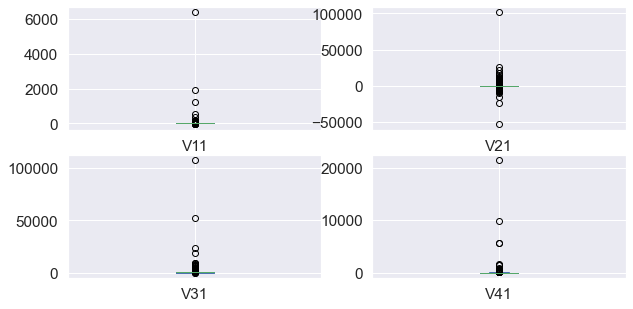

In [13]:
fig, ax = plt.subplots(2, 2, figsize=(10, 5))
axe = ax.ravel()
manu.iloc[:,10].plot.box(ax=axe[0])
manu.iloc[:,20].plot.box(ax=axe[1])
manu.iloc[:,30].plot.box(ax=axe[2])
manu.iloc[:,40].plot.box(ax=axe[3])

The boxplots indicate a large number of outliers that we will need to deal with during the preprocessing phase. Another useful information is the correlation among the financial ratios. The correlation among predictiors in one given year looks like this:


 > init() called.



<AxesSubplot:>

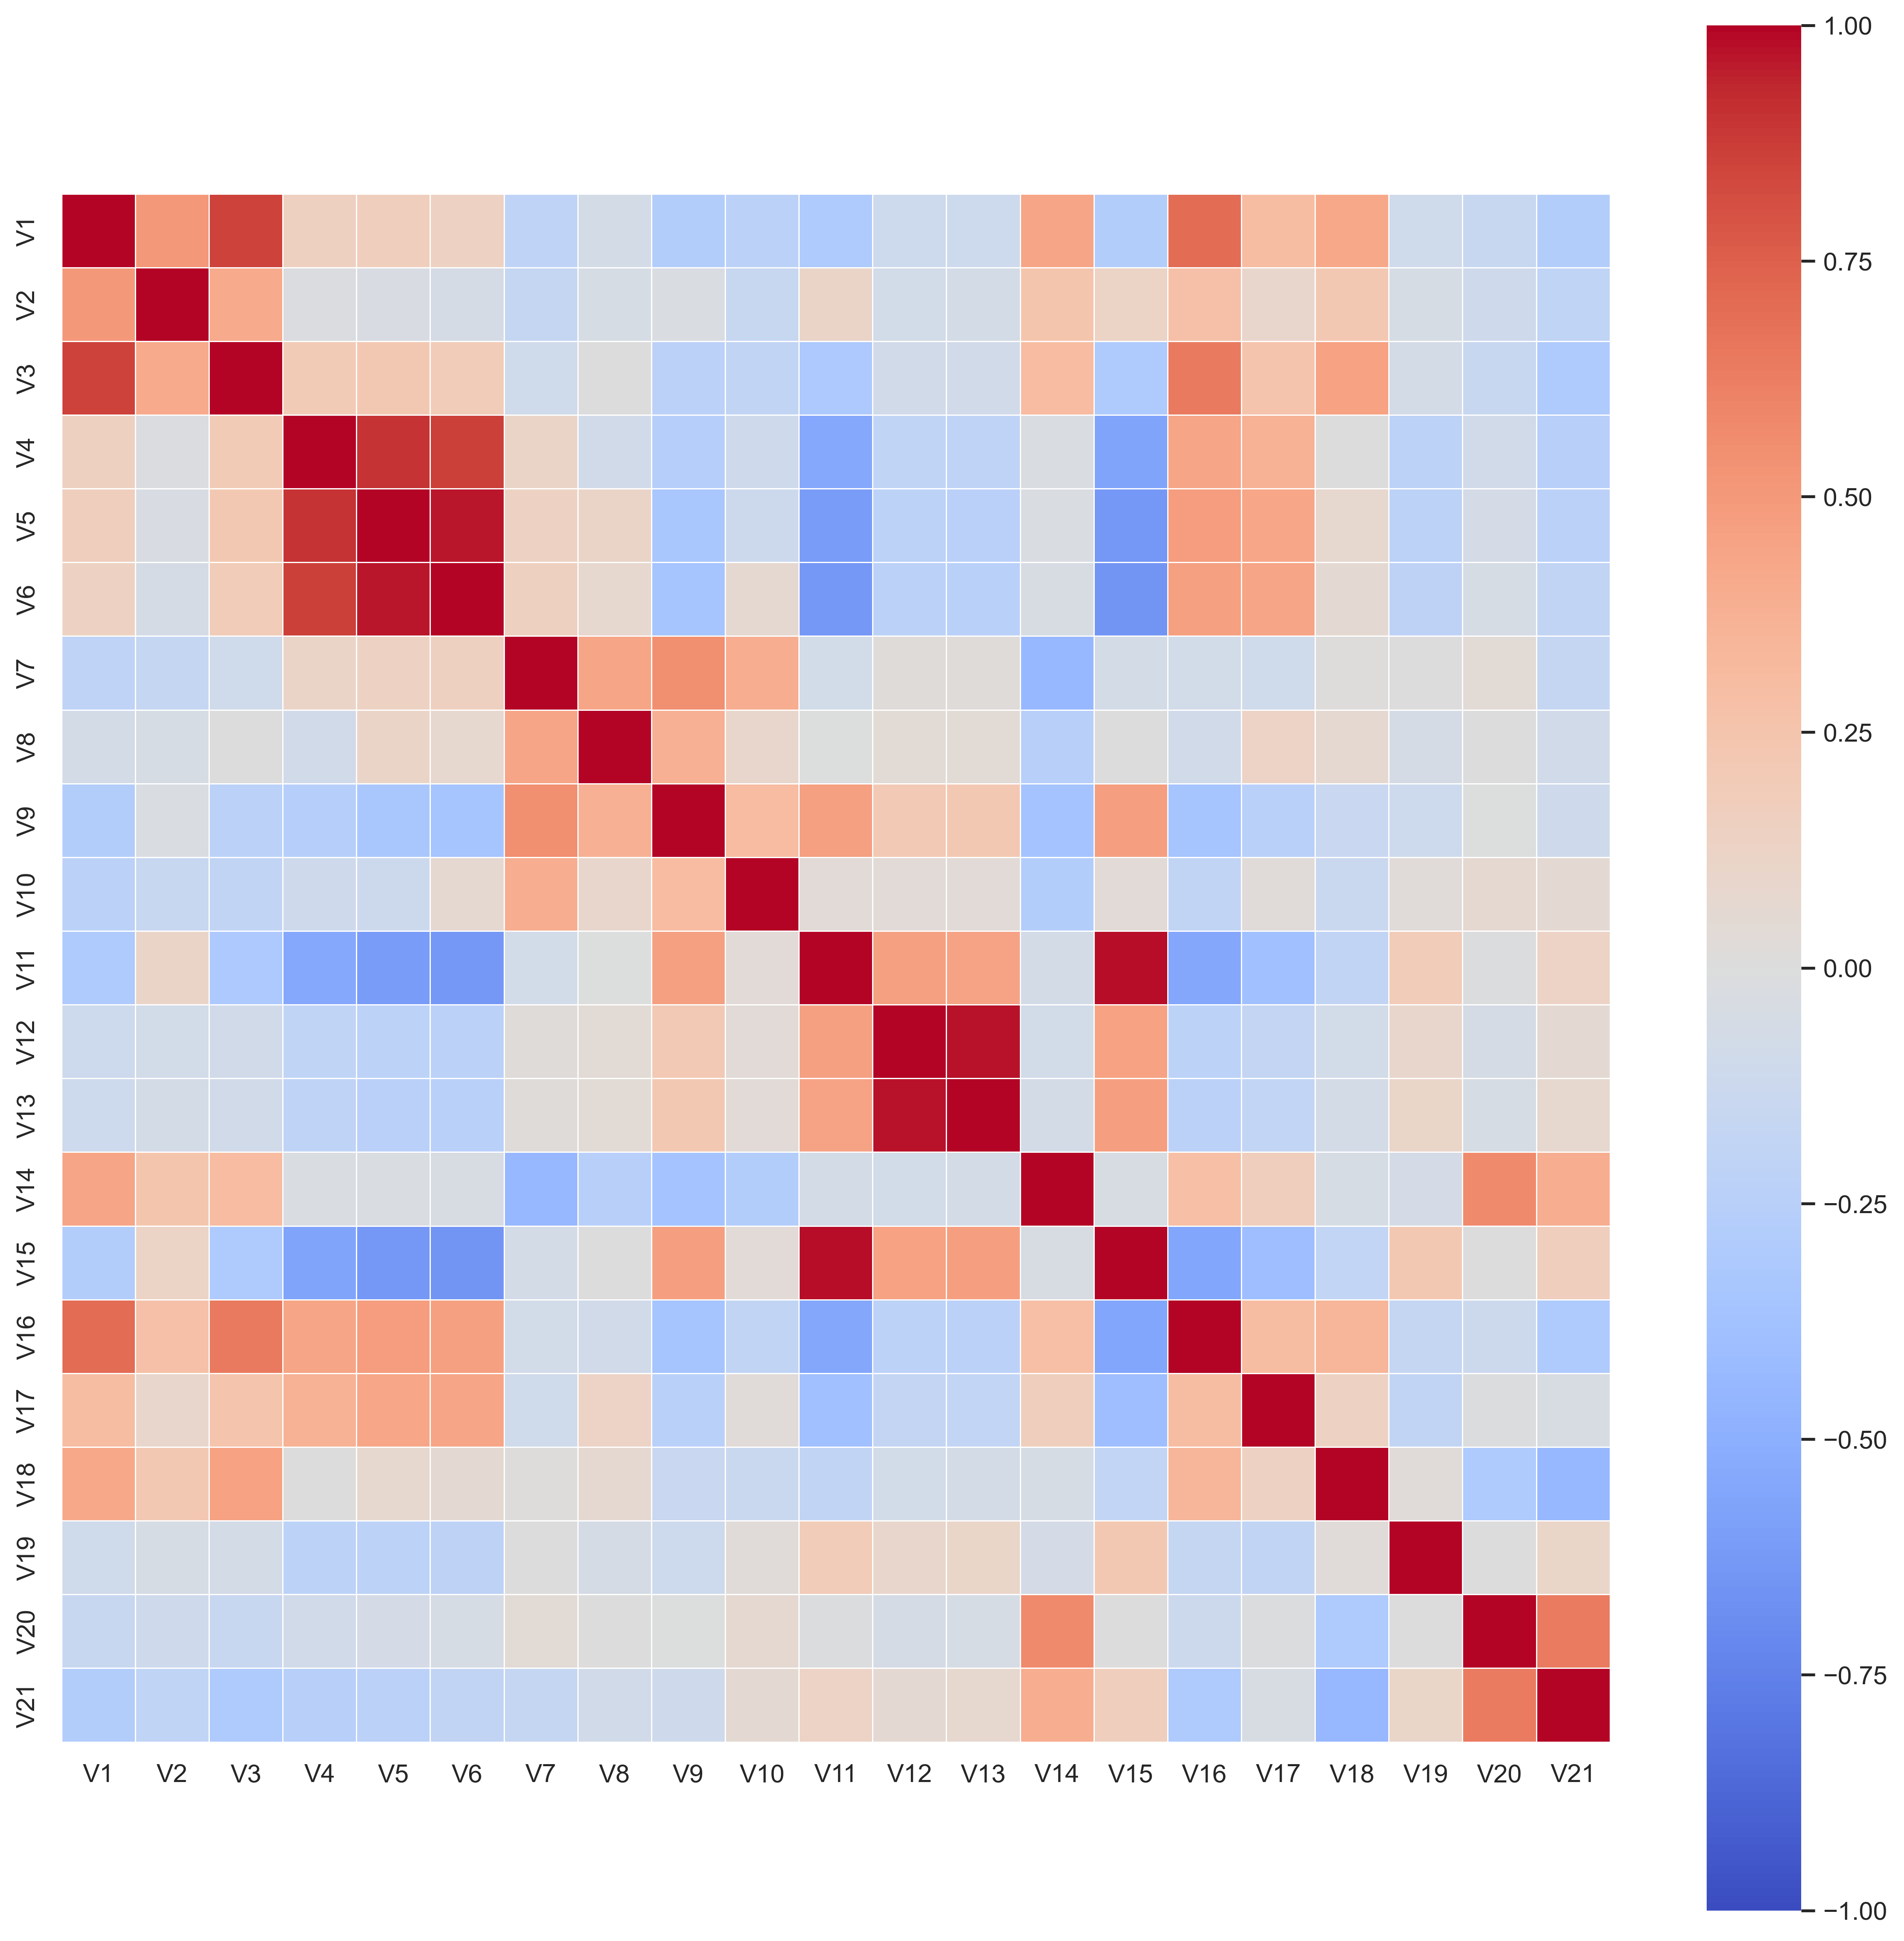

In [15]:
# Correlation matrix
wins = WinsorTrans(alpha = 0.05)
X_winsor = wins.fit_transform(X)
plt.figure(figsize = (15, 15), dpi = 400)
sns.set(font_scale = 1)
cor1 = X_winsor.iloc[:, np.arange(21)].corr()
sns.heatmap(cor1, vmin = -1, vmax = 1, square = True,  linewidths = 0.2, linecolor = 'white', cmap = 'coolwarm')

As expected, some of the financial ratios are highly correlated, either positively or negaitvely. Although this is an interesting information, we will fortunately not need to deal with the correlation, as neural networks can create their own (possibly uncorrelated) transformations of the data and other ML algorithms, such as those based on decision trees, are also robust to highly correlated data. 

Next up, we can execute the main split into training and testing data. I opted to do a 80%/20% train/test split. Another problem is the large discrepancy between the negative class (financially healthy companies) and the positive class (the companies that filed for bankruptcy): 

In [16]:
a = manu.iloc[:,63].value_counts()
print('Positive class: %d observations, (%.2f%% of data)' % (a[0], 100 *  a[0] / (a.sum())))
print('Negative class: %d observations, (%.2f%% of data)' % (a[1], 100 *  a[1] / (a.sum())))

Positive class: 19386 observations, (99.49% of data)
Negative class: 100 observations, (0.51% of data)


Since this is a highly imbalanced dataset, we need to stratify the train/test split by the output variable. We will also need to deal with the imbalance during training, by either undersampling the negative class or oversampling the positive class (dupliacation or SMOTE). 

In [17]:
# Select columns & Train test split 
from sklearn.model_selection import train_test_split as tts
col_selector = SelectCols(cutoff = 0.3)
X = col_selector.fit_transform(X)
X_tr, X_ts, y_tr, y_ts = tts(X, y, 
                             test_size = 0.2, 
                             stratify = y, 
                             random_state = 10)
[y_tr.shape, y_ts.shape] 


 > init() called.



[(15588,), (3898,)]

After the split, I decided to divide the hyperparameter optimalization for my neural network into 2 steps: The preprocessing hyperparameters, and the neural network hyperparameters. Ideally, we would do this in one go, but since I will be using grid search cross-validation to find the optimal values of these hyperparameters, such process would take too much time. I therefore assumed that the optimal data cleaning process is independent from the neural network design process. 

In the next cell, I designed the metric by which I will evaluate the quality of my classifiers. I opted for the partial AUC criterion; for brevity, I will not describe the topic of evaluating binary classifiers. 

In [18]:
# Preprocessing hyperparameter tuning
# List for pAUC metric
first = list(range(31))
xseq = [x / 100 for x in first] # max_fpr = (0, 0.3)

For the first step (optimalization of preprocessing hyperparameters), I designed a simple neural network with one hidden layer with 20 neurons. I chose the relu activation function for hidden neurons and otherwise the default setting for a binary classifier neural net. The net is also regularized by the dropout method. 

I want to add the neural net at the end of my machine learning pipeline, therefore I created this *create_net()* function which creates a Keras model, which is then wrapped in a KerasClassifier wrapper. 

In [19]:
# Neural network creator function 
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.metrics import AUC
def create_net():
    net = Sequential()
    net.add(Dropout(0.3, input_shape = (60, )))
    net.add(Dense(20, activation = 'relu'))
    net.add(Dropout(0.5))
    net.add(Dense(1, activation = 'sigmoid'))
    net.compile(loss = 'binary_crossentropy', 
                optimizer = 'adam', 
                metrics = AUC(thresholds = xseq))
    return net
keras_est = KerasClassifier(build_fn = create_net, 
                            verbose = 1, epochs = 90, batch_size = 128)

In the next step I created the grid of possible hyperparameters setting for preprocessing. The individual steps are then ordered in the *imbpipeline*, which is a Pipeline imported from the *imbalanced-learn* module, which allows me to add undersampling and oversampling to the pipe. This is essential for working with heavily imbalanced datasets, as I am allowing the pipeline to find the best combination of oversampling the positive class (via SMOTE or random oversampling) and undersampling the negative class (via random undersampling, although other techniques can be used).

The imputation will be done by the k-nearest neighbors algorithm, as imputation by the mean showed poor results in previous runs. As described earlier, winsorization will be used to deal with the outliers. Scaling of the data will be done by min-max scaling.

In [20]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import OneSidedSelection
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
preproc_grid = [{
    'outs__alpha' : [0.02, 0.05, 0.1],
    'scaler' : [MinMaxScaler()],
    'imputer' : [KNNImputer()],
    'imputer__n_neighbors' : [3, 5, 7],
    'us' : [RandomUnderSampler()],
    'os' : [RandomOverSampler(), SMOTE()],
    'us__sampling_strategy' :  [0.01, 0.02, 0.05],
    'os__sampling_strategy' : [0.75, 1],
}]

In [21]:
# Preprocessing pipeline
pp = imbpipeline(steps = [['outs', WinsorTrans()], 
                          ['scaler', MinMaxScaler()],
                          ['imputer', KNNImputer()], 
                          ['us', RandomUnderSampler()],
                          ['os', SMOTE()], 
                          ['net', keras_est]])


 > init() called.



After our pipline with its grid has been defined, we can continue to use the *GridSearchCV* function that will repeatedly train the predefined neural net with various hyperparameter settings and test its quality of predictions via cross-validation. This took a very long time (over 15-20 hours if I remember correctly), so it is important to save the .csv file that contains the results of our grid search cross-validaiton, as well as the final model trained on the whole training set.

Since this is just a notebook example of my project and I already have all my results saved, I will not run any code that would either cause training new models to begin or try to save these models.

In [22]:
# Grid search CV for preprocessing hyperparameters
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, roc_auc_score
part_auc = make_scorer(roc_auc_score, max_fpr = 0.3) # define new scoring metric 
grid_pre = GridSearchCV(estimator = pp, verbose = 4, scoring = part_auc, param_grid = preproc_grid, cv = 4,
                       return_train_score = True)
#grid_pre.fit(X_tr, y_tr)

The reason why we added all the preprocessing steps into a pipeline rather than conducted the tranformation before training, is to avoid data leakage. Data leakage is a rather complex problem to mathematically describe and therefore I will not get into details. Basically, we need to execute the same transformation on the training sets as on the validation sets, otherwise we would get (optimistically) skewed results of our final classifier.

In [23]:
#pd.DataFrame(grid_pre.cv_results_).to_csv('preprocess_end.csv')

In [24]:
# Save model 
#preprocess_mod = grid_pre.best_estimator_.steps[5][1].model.to_json()
#open('preprocess_net_konec', 'w').write(preprocess_mod)
# And its weights 
#grid_pre.best_estimator_.steps[5][1].model.save_weights('preprocess_net_konec_weights.h5', overwrite = True)

We can now move up to the second stage; setting the hyperparameters of the actual neural network. We have saved the best results for our preprocessing steps and we will 'hardcode' them into our next pipeline. I defined a new function to create a general neural net with various number of hidden layers, hidden neurons, various choice of activation funciton, regularization etc.:

In [25]:
# Neural network creator function with dropout/L1/L2 regularizations 
from keras import regularizers 
def create_net_reg(layer_sizes = [60], optimizer = 'adam',
                   activ_hidden = 'relu', lamb = 0.01,
                   typ = 'drop', dropout_input = 0.3, 
                   dropout_dense = 0.5):
    net = Sequential()
    if typ == 'l2': 
        reg = regularizers.l2(lamb)
        net.add(Dense(layer_sizes[0], input_dim = 60, 
                      activation = activ_hidden, 
                      kernel_regularizer = reg,
                      bias_regularizer = reg))
        for layer_size in layer_sizes[1:]:
            net.add(Dense(layer_size, activation = activ_hidden, 
                          kernel_regularizer = reg,
                          bias_regularizer = reg))
    if typ == 'l1': 
        reg = regularizers.l1(lamb)
        net.add(Dense(layer_sizes[0], input_dim = 60, 
                      activation = activ_hidden,
                      kernel_regularizer = reg,
                      bias_regularizer = reg))
        for layer_size in layer_sizes[1:]:
            net.add(Dense(layer_size, activation = activ_hidden,
                          kernel_regularizer = reg,
                          bias_regularizer = reg))
    if typ == 'drop':
        net.add(Dropout(dropout_input, input_shape = (60, )))
        for layer_size in layer_sizes:
            net.add(Dense(layer_size, activation = activ_hidden))
            net.add(Dropout(dropout_dense))
    net.add(Dense(1, activation = 'sigmoid'))
    net.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = AUC(thresholds = xseq))
    return net
keras_est_reg = KerasClassifier(build_fn = create_net_reg, verbose = 1, epochs = 60, batch_size = 128)

The process is very similar to the previous case, except we will define the exact preprocessing steps and define a new grid of possible hyperparameter combinations for the actual neural network. The *RandomizedSearchCV* function is used to find the best combinations of hyperparameters by evaluating the models on the validation datasets via cross-validation. The only differnce from *GridSearchCV* is our ability to choose the number of hyperparameter combinations we will choose. I settled for 200 combinations, which already comes to training 800 neural nets combined with the rather lengthy preprocessing steps to avoid data leakage. 

In [26]:
# Define pipelines
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import OneSidedSelection
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
net = imbpipeline(steps = [['outs', WinsorTrans(alpha = 0.05)], 
                           ['scaler', MinMaxScaler()],
                           ['imputer', KNNImputer(n_neighbors = 5)], 
                           ['us', RandomUnderSampler(sampling_strategy = 0.02)], 
                           ['os', SMOTE(sampling_strategy = 0.75)], 
                           ['net', keras_est_reg]])
fin_grid = [
    {
    'net__layer_sizes' : [[20], [40], [60], [30, 10], 
                          [50, 30], [20, 10, 5]],
    'net__optimizer' : ['adam', 'rmsprop'], 
    'net__activ_hidden' : ['relu', 'tanh'],
    'net__lamb' : [0.01, 0.001, 0.0001], 
    'net__typ' : ['l2']
},
    {
    'net__layer_sizes' : [[20], [40], [60], [30, 10], 
                          [50, 30], [20, 10, 5]],
    'net__optimizer' : ['adam', 'rmsprop'], 
    'net__activ_hidden' : ['relu', 'tanh'],
    'net__dropout_input' : [0.1, 0.3, 0.5],
    'net__dropout_dense' : [0.3, 0.5, 0.7],
    'net__typ' : ['drop']  
}]


 > init() called.



This learning process also takes a really long time (over 24 hours), so it is important that I saved the results after executing these blocks of code.

In [27]:
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV
part_auc = make_scorer(roc_auc_score, max_fpr = 0.3)
grid_net = RandomizedSearchCV(estimator = net, verbose = 4, scoring = part_auc, param_distributions = fin_grid, cv = 4,
                              n_iter = 200, return_train_score = True)
#grid_net.fit(X_tr, y_tr)

In [28]:
# Save the results
#pd.DataFrame(grid_final.cv_results_).to_csv('net_konec.csv')

In [29]:
# Save the model 
#final_mod = grid_final.best_estimator_.steps[5][1].model.to_json()
#open('konec_net3.json', 'w').write(final_mod)
# And its weights 
#grid_final.best_estimator_.steps[5][1].model.save_weights('konec_net_weights3.h5', overwrite = True)

Since I already trained and saved the best neural network model as well as the other ML algorithms used (logistic regression, random forest and gradient boosting machine), we can simply load the models and compare them. The process of optimalization for the other algortihms was very similar that of the neural network and the code blocks are shown lower in the project.

Let us move on and finally compare the models; I will load the already trained models and their predictions. Since the neural network is loaded in a different format, I need to do the preprocessing step manually on the test dataset.  

In [30]:
# Final evalutaion of benchmark models/neural net, loading finished models
import joblib 
rf = joblib.load('rf_upraveny.pkl')
logreg = joblib.load('logreg_konec.pkl')
gbm = joblib.load('gbm_konec.pkl')
rf_probs = rf.predict_proba(X_ts)
logreg_probs = logreg.predict_proba(X_ts)
gbm_probs = gbm.predict_proba(X_ts)

In [31]:
## Final evaluaiton, ANN
from sklearn.pipeline import Pipeline
from keras.models import model_from_json
ann = model_from_json(open('konec_net3.json').read())
ann.load_weights('konec_net_weights3.h5')

# Create pipeline again 
preprocess = Pipeline(steps = [['outs', WinsorTrans(alpha = 0.05)], 
                               ['scaler', MinMaxScaler()],
                               ['imputer', KNNImputer(n_neighbors = 5)]])
preprocess.fit(X_tr)
X_ts_pp = preprocess.transform(X_ts)


 > init() called.



In [32]:
# ANN predictions
ann_probs = ann.predict(X_ts_pp)

The best and robust way to compare several binary classifiers is arguably the Receiver operating characteristic (ROC curve). This [curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) plots the true positive rate (TPR) agianst the false positive rate (FPR) for various cut-off values of a binary classifier. Remember, the output of our algorithm is not the predicted category; the output is merely a *probability* our model thinks that the given observation belongs to the positive class. It is then up to the analyst to choose the cut-off value to suit the needs of a problem we are trying to solve by training these machine learning algorithms. Depending on the nature of our problem, a type I error (false positive) might have way worse implications in real life than a type II error (false negative), or vice versa. 

The ROC curve always starts in the origin and ends in the (1,1) point. The better the classifier, the closer its ROC curve is to the upper left corner (or (0, 1) point), which implies that the classifier is able to predict all observations in the test set correcly, for some cut-off value. In real life, it is very rare to encounter data for which a perfect classifer can be created. The *Area Under Curve* (AUC) is therefore used to compare several models by a single metric. This value between 0 and 1 literally means the area under the ROC curve. A model that randomly guesses the category of observations will have AUC around 0.5 and models close to 1 are those that are very good at predicting the correct category. Hence, the higher the AUC, the more precise our model is. 

This is very important especially in our case, as we are dealing with a highly imbalanced dataset. Some simpler metrics, such as accuracy, are going to be misleading, as a pseudomodel which predicts only negative class for all observations will achieve about 99.5% accuracy, which may seem great, while in reality the model is completely useless.  

In this project, I used the *partial* AUC metric, which uses a standardized area under a part of the ROC curve. For example, I looked at the curve at the parts where false positive rate was less than 30%, as I am less interested in how the models performed with such a high FPR. 

Text(0, 0.5, 'TPR')

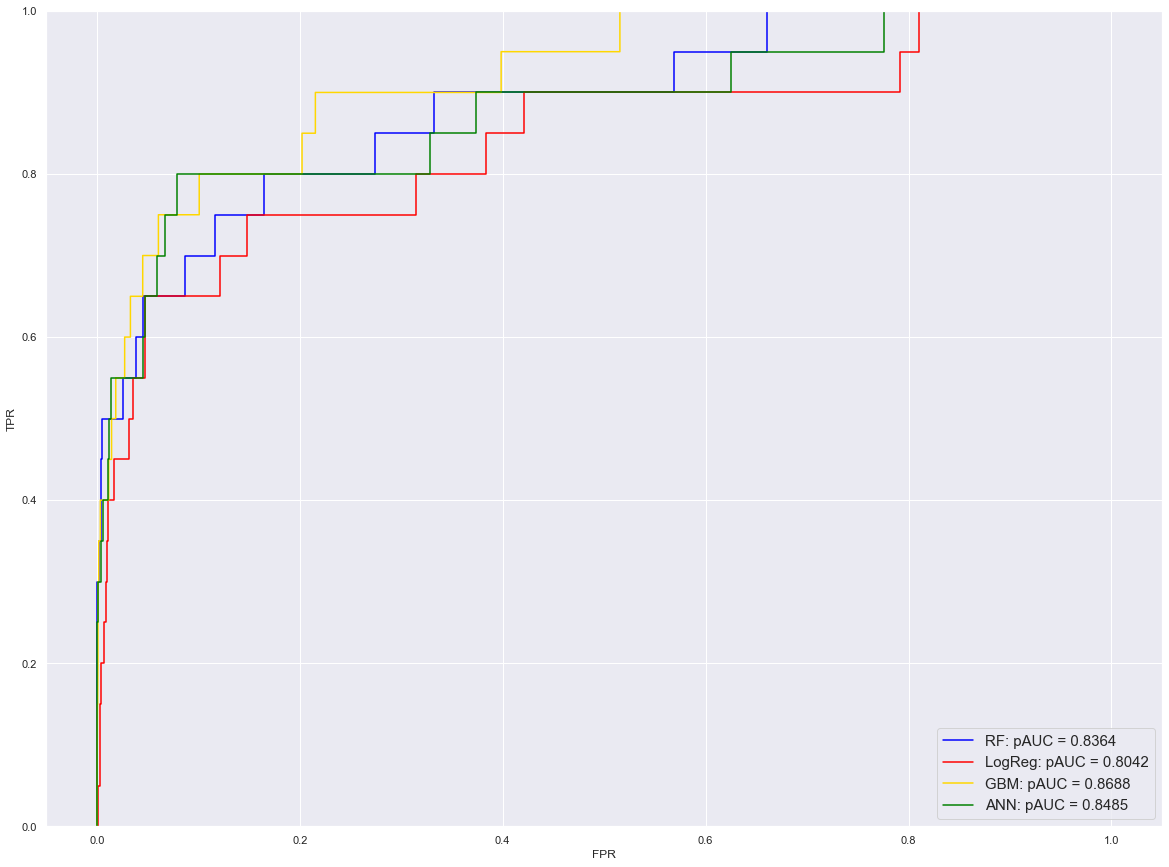

In [34]:
# ROC curve
import sklearn.metrics as metrics
f = plt.figure()
plt.rcParams["figure.figsize"] = (20,15)
fpr_rf, tpr_rf, threshold_rf = metrics.roc_curve(y_ts, rf_probs[:,1])
fpr_logreg, tpr_logreg, threshold_logreg = metrics.roc_curve(y_ts, logreg_probs[:,1])
fpr_gbm, tpr_gbm, threshold_gbm = metrics.roc_curve(y_ts, gbm_probs[:,1])
fpr_ann, tpr_ann, threshold_ann = metrics.roc_curve(y_ts, ann_probs)
roc_auc_rf = metrics.roc_auc_score(y_ts, rf_probs[:,1], max_fpr = 0.3)
roc_auc_logreg = metrics.roc_auc_score(y_ts, logreg_probs[:,1], max_fpr = 0.3)
roc_auc_gbm = metrics.roc_auc_score(y_ts, gbm_probs[:,1], max_fpr = 0.3)
roc_auc_ann = metrics.roc_auc_score(y_ts, ann_probs, max_fpr = 0.3)
plt.plot(fpr_rf, tpr_rf, label = 'RF: pAUC = %0.4f' % roc_auc_rf, color = 'blue')
plt.plot(fpr_logreg, tpr_logreg, label = 'LogReg: pAUC = %0.4f' % roc_auc_logreg, color = 'red')
plt.plot(fpr_gbm, tpr_gbm, label = 'GBM: pAUC = %0.4f' % roc_auc_gbm, color = 'gold')
plt.plot(fpr_ann, tpr_ann, label = 'ANN: pAUC = %0.4f' % roc_auc_ann, color = 'green')
plt.ylim([0, 1])
plt.legend(loc = 'lower right', prop={'size': 15})
plt.xlabel('FPR')
plt.ylabel('TPR')

We may take a look at the pAUC/AUC scores our final models achieved on the test data. The partial AUC was calculated on the part of the ROC curve where the false positive rate was less than 30%. 

In [35]:
# pAUC, test data
print('Neural network pAUC on test data: %.5f.' % (metrics.roc_auc_score(y_ts, ann_probs, max_fpr = 0.3)))
print('Random forest pAUC on test data: %.5f.' % (metrics.roc_auc_score(y_ts, rf_probs[:,1], max_fpr = 0.3)))
print('Logistic regression pAUC on test data: %.5f.' % (metrics.roc_auc_score(y_ts, logreg_probs[:,1], max_fpr = 0.3)))
print('Gradient boosting machine pAUC on test data: %.5f.' % (metrics.roc_auc_score(y_ts, gbm_probs[:,1], max_fpr = 0.3)))


Neural network pAUC on test data: 0.84848.
Random forest pAUC on test data: 0.83635.
Logistic regression pAUC on test data: 0.80422.
Gradient boosting machine pAUC on test data: 0.86884.


In [36]:
# AUC, test data
print('Neural network AUC on test data: %.5f.' % (metrics.roc_auc_score(y_ts, ann_probs)))
print('Random forest AUC on test data: %.5f.' % (metrics.roc_auc_score(y_ts, rf_probs[:,1])))
print('Logistic regression AUC on test data: %.5f.' % (metrics.roc_auc_score(y_ts, logreg_probs[:,1])))
print('Gradient boosting machine AUC on test data: %.5f.' % (metrics.roc_auc_score(y_ts, gbm_probs[:,1])))

Neural network AUC on test data: 0.87762.
Random forest AUC on test data: 0.88348.
Logistic regression AUC on test data: 0.83908.
Gradient boosting machine AUC on test data: 0.91741.


As we can see, the neural network fell short of decision tree-based algortihms such as random forest or GBM. However, it had the best performance at the true positive rate equal to 80%, meaning it achieved the smallest false positive rate among the trained algorithms. 

The actual choice of the cut-off point depends on how risky we want to be when choosing which companies we want to invest in. A lower cut-off point ensures that most of the bankrupt companies will be labeled correctly, but a lot of financially healthy companies will be also incorreclty labeled as going banrkupt. On the other hand, higher cut-off point lowers the value of incorrectly labeled healthy companies, but raises the risk that some of the companies predicted as healthy were, in reality, going bankrupt. This choice wholly relies on the business decision. 

In this project, I chose the 80% true positive rate boundary and its corresponding cut-off value. We can look at the *confusion matrices*, which tell us how many observations from the positive/negative class were labeled correctly (elements on the diagonal) and how many of them were labeled incorrectly (elements not on the diagonal)

In [37]:
# Confusion matrices
from sklearn.metrics import confusion_matrix 
rf_p = threshold_rf[tpr_rf == 0.8][0]
logreg_p = threshold_logreg[tpr_logreg == 0.8][0]
gbm_p = threshold_gbm[tpr_gbm == 0.8][0]
ann_p = threshold_ann[tpr_ann == 0.8][0]

In [38]:
print('Random Forest:')
print(confusion_matrix(y_ts, (rf_probs[:,1] >= rf_p).astype('int')))

Random Forest:
[[3238  640]
 [   4   16]]


In [39]:
print('Logistic Regression:')
print(confusion_matrix(y_ts, (logreg_probs[:,1] >= logreg_p).astype('int')))

Logistic Regression:
[[2658 1220]
 [   4   16]]


In [40]:
print('GBM:')
print(confusion_matrix(y_ts, (gbm_probs[:,1] >= gbm_p).astype('int')))

GBM:
[[3487  391]
 [   4   16]]


In [41]:
print('ANN:')
print(confusion_matrix(y_ts, (ann_probs >= ann_p).astype('int')))

ANN:
[[3573  305]
 [   4   16]]


The price we pay so at least 80% of banrkupt companies are labeled correctly, is pretty high. The artificial neural network, which was the best performer at this TPR level, incorrectly predicted 305 companies as bankrupt, even though in reality, they were financially healthy. This might seem as a high number, but since predicting bankruptcy solely from financial ratios is a rather complex problem, this model did a pretty okay job. 

Next up, we may look at the cut-off values for each model that correspond to the TPR = 0.8 level.

In [42]:
# Cut-off points for TPR = 0.8
print('Optimal cut-off point, random forest: %.3f.' % round(threshold_rf[tpr_rf == 0.8][0], 3))
print('Optimal cut-off point, logistic regression: %.3f.' % round(threshold_logreg[tpr_logreg == 0.8][0], 3))
print('Optimal cut-off point, GBM: %.3f.' % round(threshold_gbm[tpr_gbm == 0.8][0], 3))
print('Optimal cut-off point, neural net: %.3f.' % round(threshold_ann[tpr_ann == 0.8][0], 3))

Optimal cut-off point, random forest: 0.524.
Optimal cut-off point, logistic regression: 0.009.
Optimal cut-off point, GBM: 0.397.
Optimal cut-off point, neural net: 0.464.


The following code illustrates the definition and training of benchmark ML models used in this project: A random forest, logistic regression and gradient boosting machine. In the name of consistency, I used the same preprocessing paradigm as I did for the neural network. In reality, decision tree-based models allow us to skip some of the steps (such as winsorization) as they might even hurt the performance of these models via loss of information. I wanted to maintain 'fairness' so I evaluated the performance of these models on the same data, hence I kept the same preprocessing steps. 

In [43]:
# Benchmark models
# Random Forest 
from sklearn.ensemble import RandomForestClassifier as RFC
rf = imbpipeline(steps = [['outs', WinsorTrans()],
                          ['scaler', MinMaxScaler()],
                          ['imputer', KNNImputer()], 
                          ['us', RandomUnderSampler()], 
                          ['os', RandomOverSampler()], 
                          ['clf', RFC()]])
params = {
    'outs__alpha' : [0.05],
    'imputer' : [KNNImputer(n_neighbors = 5)],
    'os' : [SMOTE(sampling_strategy = 0.75)],
    'us' : [RandomUnderSampler(sampling_strategy = 0.02)],
    'clf__n_estimators' : [600, 800, 1000],
    'clf__max_depth' : [2, 3, 4 , 5],
    'clf__max_features' : [8, 10, 12]
}


 > init() called.



In [44]:
from sklearn.model_selection import GridSearchCV
part_auc = make_scorer(roc_auc_score, max_fpr = 0.3)
forest = GridSearchCV(estimator = rf, 
                      verbose = 4,
                      scoring = part_auc,
                      param_grid = params,
                      cv = 4,
                      return_train_score = True)
#forest.fit(X_tr, y_tr)

In [45]:
import joblib 
#joblib.dump(forest.best_estimator_, 'rf_konec.pkl')
#pd.DataFrame(forest.cv_results_).to_csv('rf_konec.csv')

In [46]:
# Retrained RF 
rf_final = imbpipeline(steps = [['outs', WinsorTrans()],
                                ['scaler', MinMaxScaler()],
                                ['imputer', KNNImputer()], 
                                ['us', RandomUnderSampler()], 
                                ['os', RandomOverSampler()], 
                                ['clf', RFC(n_estimators = 600,
                                            max_depth = 3,
                                            max_features = 12)]])
#rf_final.fit(X_tr, y_tr)


 > init() called.



In [47]:
#joblib.dump(rf_final, 'rf_upraveny.pkl')

In [48]:
# Logistic regression
from sklearn.linear_model import LogisticRegression 
logreg = imbpipeline(steps = [['outs', WinsorTrans()],
                              ['scaler', MinMaxScaler()],
                              ['imputer', KNNImputer()], 
                              ['clf', LogisticRegression(solver = 'liblinear',
                                                         max_iter = 10000,
                                                         class_weight = 'balanced')]])
params = {
    'outs__alpha' : [0.05],
    'imputer' : [KNNImputer(n_neighbors = 5)],
    'clf__penalty' : ['l2', 'l1'],
    'clf__C': [0.01, 0.1, 1, 10, 100, 1000]
}
# C = 1/lambda, 1 - 1000, penalty l1/l2


 > init() called.



In [49]:
regres = GridSearchCV(estimator = logreg, 
                      verbose = 4,
                      scoring = part_auc,
                      param_grid = params,
                      cv = 4,
                      return_train_score = True)
#regres.fit(X_tr, y_tr)

In [50]:
#pd.DataFrame(regres.cv_results_).to_csv('logreg_konec.csv')
#joblib.dump(regres.best_estimator_, 'logreg_konec.pkl')

In [51]:
# Gradient Boosting Machine 
from sklearn.ensemble import GradientBoostingClassifier as GBC
gbm = imbpipeline(steps = [['outs', WinsorTrans()],
                             ['scaler', MinMaxScaler()],
                             ['imputer', KNNImputer()], 
                             ['us', RandomUnderSampler()], 
                             ['os', RandomOverSampler()], 
                             ['clf', GBC()]])
params = {
    'outs__alpha' : [0.05],
    'imputer' : [KNNImputer(n_neighbors = 5)],
    'os' : [SMOTE(sampling_strategy = 0.75)],
    'us' : [RandomUnderSampler(sampling_strategy = 0.02)],
    'clf__n_estimators' : [50, 100, 300, 500],
    'clf__max_depth' : [2, 3, 4],
    'clf__learning_rate' : [1, 0.1, 0.01, 0.001]
}


 > init() called.



In [52]:
gradboost = GridSearchCV(estimator = gbm, 
                         verbose = 4,
                         scoring = part_auc,
                         param_grid = params,
                         cv = 4,
                         return_train_score = True)
#gradboost.fit(X_tr, y_tr)

In [98]:
#pd.DataFrame(gradboost.cv_results_).to_csv('gbm_konec.csv')
#joblib.dump(gradboost.best_estimator_, 'gbm_konec.pkl')

['gbm_konec.pkl']

## Saliency
In the last part, I tried to define the *saliency* variable for each of the predictors according to an article written by duJardin [(link here)](https://www.sciencedirect.com/science/article/abs/pii/S0925231210001098). Since neural networks are a *black-box* algorithm, it is fairly difficult to determine which of the predictors were important in predicting the output variable. However, there have been some methods developed in the previous decade. They are usually described under the umbrella term *sensitivity analysis*. 

My main aim was to create a simple neural network with one hidden layer and simple architecture. I repeatedly trained this simple network and computed the saliency variable for each of the predictors, defined by duJardin. Then I looked at the predictors that repeatedly scored among the top in saliency, for various splits of the data. This is a very heuristic way of looking at the variable importance, but it might give us some insight into which of the features were more imporant that others.

I will not get into details of the definition of saliency and my results; they can be found in my Master's thesis which is on my github page (unfortunately, it is written in Slovak). 

In [53]:
# Saliency 
from sklearn.pipeline import Pipeline 
sampler = imbpipeline(steps = [['outs', WinsorTrans(alpha = 0.05)],
                           ['scaler', MinMaxScaler()],
                           ['imputer', KNNImputer(n_neighbors = 5)],
                           ['us', RandomUnderSampler(sampling_strategy = 0.02)],
                           ['os', SMOTE(sampling_strategy = 0.75)]])
transformer = Pipeline(steps = [['outs', WinsorTrans(alpha = 0.05)], 
                       ['scaler', MinMaxScaler()],
                       ['imputer', KNNImputer(n_neighbors = 5)]])


 > init() called.


 > init() called.



In [54]:
def create_net_sal():
    net = Sequential()
    net.add(Dense(20, input_dim = 60, activation = 'relu'))
    net.add(Dense(1, activation = 'sigmoid'))
    net.compile(loss = 'binary_crossentropy', 
                optimizer = 'adam', 
                metrics = AUC(thresholds = xseq))
    return net

In [55]:
from keras.callbacks import EarlyStopping
# Code test
X_tra, X_val, y_tra, y_val = tts(X_tr, y_tr, test_size = 0.25, stratify = y_tr)
X_tra_pp = sampler.fit_resample(X_tra, y_tra)
transformer.fit(X_tra)
X_val_pp = transformer.transform(X_val)
X_val = (X_val_pp, y_val)
callback = EarlyStopping(monitor = 'val_loss', patience = 10)
net = create_net_sal()
#net.fit(X_tra_pp[0], X_tra_pp[1], validation_data = X_val, epochs = 300, verbose = 1, batch_size = 128,
#                callbacks = [callback])


In [56]:
def saliency(model):
  k = model.layers[0].get_weights()[0].shape[0]
  sal = [0] * k
  abs1 = abs(model.layers[0].get_weights()[0])
  abs2 = abs(model.layers[1].get_weights()[0])
  sec = abs2 / abs2.sum()
  fir = abs1.sum(axis = 0)
  for i in np.arange(k):
    sal[i] = float(np.dot(abs1[i,:] / fir, sec))
  return(pd.Series(sal))

In [57]:
S = pd.DataFrame()
for i in np.arange(20):
    X_tra, X_val, y_tra, y_val = tts(X_tr, y_tr, 
                                    test_size = 0.25, 
                                    stratify = y_tr)
    X_tra_pp = sampler.fit_resample(X_tra, y_tra)
    transformer.fit(X_tra)
    X_val_pp = transformer.transform(X_val)
    val = (X_val_pp, y_val)
    for j in np.arange(5):
        net = create_net_sal()
        net.fit(X_tra_pp[0], X_tra_pp[1], validation_data = val, 
                epochs = 300, verbose = 1, batch_size = 128,
                callbacks = [callback])
        ind = saliency(net).nlargest(20).index
        S = S.append(pd.Series(ind), ignore_index = True)

Epoch 1/300
42/42 [==============================] - 2s 22ms/step - loss: 0.5771 - auc_1: 0.5635 - val_loss: 0.4770 - val_auc_1: 0.6494
Epoch 2/300
42/42 [==============================] - 1s 15ms/step - loss: 0.4343 - auc_1: 0.7325 - val_loss: 0.4005 - val_auc_1: 0.7228
Epoch 3/300
42/42 [==============================] - 1s 15ms/step - loss: 0.3513 - auc_1: 0.8032 - val_loss: 0.3236 - val_auc_1: 0.7822
Epoch 4/300
42/42 [==============================] - 1s 14ms/step - loss: 0.3053 - auc_1: 0.8481 - val_loss: 0.2644 - val_auc_1: 0.8136
Epoch 5/300
42/42 [==============================] - 1s 14ms/step - loss: 0.2783 - auc_1: 0.8753 - val_loss: 0.2597 - val_auc_1: 0.8282
Epoch 6/300
42/42 [==============================] - 1s 15ms/step - loss: 0.2591 - auc_1: 0.8887 - val_loss: 0.2333 - val_auc_1: 0.8388
Epoch 7/300
42/42 [==============================] - 1s 15ms/step - loss: 0.2450 - auc_1: 0.9003 - val_loss: 0.2454 - val_auc_1: 0.8427
Epoch 8/300
42/42 [=============================

Epoch 61/300
42/42 [==============================] - 1s 15ms/step - loss: 0.0785 - auc_1: 0.9730 - val_loss: 0.1273 - val_auc_1: 0.8933
Epoch 62/300
42/42 [==============================] - 1s 15ms/step - loss: 0.0777 - auc_1: 0.9738 - val_loss: 0.1224 - val_auc_1: 0.8946
Epoch 63/300
42/42 [==============================] - 1s 16ms/step - loss: 0.0765 - auc_1: 0.9733 - val_loss: 0.1337 - val_auc_1: 0.8915
Epoch 64/300
42/42 [==============================] - 1s 17ms/step - loss: 0.0760 - auc_1: 0.9725 - val_loss: 0.1345 - val_auc_1: 0.8917
Epoch 65/300
42/42 [==============================] - 1s 17ms/step - loss: 0.0754 - auc_1: 0.9737 - val_loss: 0.1304 - val_auc_1: 0.8915
Epoch 66/300
42/42 [==============================] - 1s 15ms/step - loss: 0.0737 - auc_1: 0.9735 - val_loss: 0.1178 - val_auc_1: 0.8951
Epoch 1/300
42/42 [==============================] - 2s 22ms/step - loss: 0.6762 - auc_2: 0.5110 - val_loss: 0.5101 - val_auc_2: 0.6322
Epoch 2/300
42/42 [=======================

Epoch 16/300
42/42 [==============================] - 1s 15ms/step - loss: 0.1926 - auc_3: 0.9236 - val_loss: 0.2127 - val_auc_3: 0.8630
Epoch 17/300
42/42 [==============================] - 1s 16ms/step - loss: 0.1872 - auc_3: 0.9279 - val_loss: 0.2165 - val_auc_3: 0.8629
Epoch 18/300
42/42 [==============================] - 1s 16ms/step - loss: 0.1832 - auc_3: 0.9278 - val_loss: 0.1952 - val_auc_3: 0.8713
Epoch 19/300
42/42 [==============================] - 1s 16ms/step - loss: 0.1779 - auc_3: 0.9313 - val_loss: 0.1743 - val_auc_3: 0.8661
Epoch 20/300
42/42 [==============================] - 1s 17ms/step - loss: 0.1788 - auc_3: 0.9363 - val_loss: 0.1678 - val_auc_3: 0.8701
Epoch 21/300
42/42 [==============================] - 1s 15ms/step - loss: 0.1731 - auc_3: 0.9391 - val_loss: 0.1809 - val_auc_3: 0.8641
Epoch 22/300
42/42 [==============================] - 1s 14ms/step - loss: 0.1665 - auc_3: 0.9375 - val_loss: 0.1816 - val_auc_3: 0.8651
Epoch 23/300
42/42 [=====================

Epoch 13/300
42/42 [==============================] - 1s 16ms/step - loss: 0.1979 - auc_4: 0.9215 - val_loss: 0.1875 - val_auc_4: 0.8698
Epoch 14/300
42/42 [==============================] - 1s 15ms/step - loss: 0.1931 - auc_4: 0.9244 - val_loss: 0.1830 - val_auc_4: 0.8722
Epoch 15/300
42/42 [==============================] - 1s 14ms/step - loss: 0.1885 - auc_4: 0.9294 - val_loss: 0.2113 - val_auc_4: 0.8636
Epoch 16/300
42/42 [==============================] - 1s 14ms/step - loss: 0.1835 - auc_4: 0.9272 - val_loss: 0.2411 - val_auc_4: 0.8572
Epoch 17/300
42/42 [==============================] - 1s 15ms/step - loss: 0.1872 - auc_4: 0.9198 - val_loss: 0.1970 - val_auc_4: 0.8718
Epoch 18/300
42/42 [==============================] - 1s 16ms/step - loss: 0.1747 - auc_4: 0.9339 - val_loss: 0.1895 - val_auc_4: 0.8640
Epoch 19/300
42/42 [==============================] - 1s 16ms/step - loss: 0.1703 - auc_4: 0.9343 - val_loss: 0.1868 - val_auc_4: 0.8636
Epoch 20/300
42/42 [=====================

Epoch 9/300
42/42 [==============================] - 1s 15ms/step - loss: 0.2236 - auc_5: 0.9126 - val_loss: 0.2223 - val_auc_5: 0.8526
Epoch 10/300
42/42 [==============================] - 1s 15ms/step - loss: 0.2132 - auc_5: 0.9157 - val_loss: 0.2279 - val_auc_5: 0.8545
Epoch 11/300
42/42 [==============================] - 1s 15ms/step - loss: 0.2094 - auc_5: 0.9150 - val_loss: 0.2205 - val_auc_5: 0.8591
Epoch 12/300
42/42 [==============================] - 1s 16ms/step - loss: 0.1989 - auc_5: 0.9219 - val_loss: 0.2158 - val_auc_5: 0.8603
Epoch 13/300
42/42 [==============================] - 1s 17ms/step - loss: 0.1926 - auc_5: 0.9235 - val_loss: 0.1872 - val_auc_5: 0.8734
Epoch 14/300
42/42 [==============================] - 1s 22ms/step - loss: 0.1868 - auc_5: 0.9314 - val_loss: 0.1861 - val_auc_5: 0.8768
Epoch 15/300
42/42 [==============================] - 1s 19ms/step - loss: 0.1807 - auc_5: 0.9302 - val_loss: 0.1793 - val_auc_5: 0.8799
Epoch 16/300
42/42 [======================

42/42 [==============================] - 1s 19ms/step - loss: 0.0692 - auc_5: 0.9765 - val_loss: 0.1161 - val_auc_5: 0.8621
Epoch 69/300
42/42 [==============================] - 1s 20ms/step - loss: 0.0682 - auc_5: 0.9766 - val_loss: 0.1120 - val_auc_5: 0.8650
Epoch 70/300
42/42 [==============================] - 1s 20ms/step - loss: 0.0672 - auc_5: 0.9776 - val_loss: 0.1110 - val_auc_5: 0.8646
Epoch 71/300
42/42 [==============================] - 1s 18ms/step - loss: 0.0663 - auc_5: 0.9773 - val_loss: 0.1032 - val_auc_5: 0.8671
Epoch 72/300
42/42 [==============================] - 1s 18ms/step - loss: 0.0654 - auc_5: 0.9778 - val_loss: 0.1079 - val_auc_5: 0.8653
Epoch 73/300
42/42 [==============================] - 1s 23ms/step - loss: 0.0643 - auc_5: 0.9776 - val_loss: 0.1193 - val_auc_5: 0.8623
Epoch 74/300
42/42 [==============================] - 1s 33ms/step - loss: 0.0711 - auc_5: 0.9718 - val_loss: 0.1171 - val_auc_5: 0.86170s - loss: 0.0733 - auc_5: 0.96 - ETA: 0s - loss: 0.072

42/42 [==============================] - 1s 34ms/step - loss: 0.0324 - auc_5: 0.9890 - val_loss: 0.0898 - val_auc_5: 0.8412
Epoch 127/300
42/42 [==============================] - 2s 36ms/step - loss: 0.0320 - auc_5: 0.9893 - val_loss: 0.0817 - val_auc_5: 0.8426
Epoch 1/300
42/42 [==============================] - 2s 37ms/step - loss: 0.6129 - auc_6: 0.5540 - val_loss: 0.4967 - val_auc_6: 0.6395
Epoch 2/300
42/42 [==============================] - 1s 27ms/step - loss: 0.4587 - auc_6: 0.7170 - val_loss: 0.4092 - val_auc_6: 0.7232
Epoch 3/300
42/42 [==============================] - 1s 28ms/step - loss: 0.3772 - auc_6: 0.7985 - val_loss: 0.3572 - val_auc_6: 0.7727
Epoch 4/300
42/42 [==============================] - 1s 28ms/step - loss: 0.3288 - auc_6: 0.8302 - val_loss: 0.2958 - val_auc_6: 0.8074
Epoch 5/300
42/42 [==============================] - 1s 29ms/step - loss: 0.2929 - auc_6: 0.8617 - val_loss: 0.2963 - val_auc_6: 0.8174
Epoch 6/300
42/42 [==============================] - 1s 30

Epoch 59/300
42/42 [==============================] - 1s 26ms/step - loss: 0.0842 - auc_6: 0.9698 - val_loss: 0.1147 - val_auc_6: 0.8517
Epoch 60/300
42/42 [==============================] - 1s 27ms/step - loss: 0.0833 - auc_6: 0.9700 - val_loss: 0.1180 - val_auc_6: 0.8516
Epoch 61/300
42/42 [==============================] - 1s 28ms/step - loss: 0.0823 - auc_6: 0.9705 - val_loss: 0.1163 - val_auc_6: 0.8523
Epoch 62/300
42/42 [==============================] - 1s 32ms/step - loss: 0.0805 - auc_6: 0.9707 - val_loss: 0.1046 - val_auc_6: 0.8562
Epoch 63/300
42/42 [==============================] - 1s 30ms/step - loss: 0.0794 - auc_6: 0.9722 - val_loss: 0.1151 - val_auc_6: 0.8525
Epoch 64/300
42/42 [==============================] - 1s 32ms/step - loss: 0.0784 - auc_6: 0.9724 - val_loss: 0.1238 - val_auc_6: 0.8509
Epoch 65/300
42/42 [==============================] - 1s 30ms/step - loss: 0.0785 - auc_6: 0.9721 - val_loss: 0.1139 - val_auc_6: 0.8535
Epoch 66/300
42/42 [=====================

42/42 [==============================] - 1s 27ms/step - loss: 0.0909 - auc_7: 0.9689 - val_loss: 0.1178 - val_auc_7: 0.8556
Epoch 47/300
42/42 [==============================] - 1s 28ms/step - loss: 0.0892 - auc_7: 0.9698 - val_loss: 0.1242 - val_auc_7: 0.8552
Epoch 48/300
42/42 [==============================] - 1s 28ms/step - loss: 0.0876 - auc_7: 0.9690 - val_loss: 0.1101 - val_auc_7: 0.8582
Epoch 49/300
42/42 [==============================] - 1s 31ms/step - loss: 0.0864 - auc_7: 0.9707 - val_loss: 0.1172 - val_auc_7: 0.8567
Epoch 50/300
42/42 [==============================] - 1s 28ms/step - loss: 0.0848 - auc_7: 0.9704 - val_loss: 0.1210 - val_auc_7: 0.8577
Epoch 51/300
42/42 [==============================] - 1s 29ms/step - loss: 0.0834 - auc_7: 0.9704 - val_loss: 0.1099 - val_auc_7: 0.8570
Epoch 52/300
42/42 [==============================] - 1s 31ms/step - loss: 0.0824 - auc_7: 0.9731 - val_loss: 0.1128 - val_auc_7: 0.8569
Epoch 53/300
42/42 [==============================] - 

42/42 [==============================] - 1s 27ms/step - loss: 0.0331 - auc_7: 0.9872 - val_loss: 0.0782 - val_auc_7: 0.8333
Epoch 106/300
42/42 [==============================] - 1s 29ms/step - loss: 0.0320 - auc_7: 0.9877 - val_loss: 0.0775 - val_auc_7: 0.8342
Epoch 107/300
42/42 [==============================] - 1s 27ms/step - loss: 0.0310 - auc_7: 0.9873 - val_loss: 0.0785 - val_auc_7: 0.8339
Epoch 108/300
42/42 [==============================] - 1s 28ms/step - loss: 0.0310 - auc_7: 0.9883 - val_loss: 0.0809 - val_auc_7: 0.8336
Epoch 109/300
42/42 [==============================] - 1s 32ms/step - loss: 0.0304 - auc_7: 0.9877 - val_loss: 0.0807 - val_auc_7: 0.8340
Epoch 1/300
42/42 [==============================] - 2s 37ms/step - loss: 0.6059 - auc_8: 0.5312 - val_loss: 0.5472 - val_auc_8: 0.6103
Epoch 2/300
42/42 [==============================] - 1s 27ms/step - loss: 0.4459 - auc_8: 0.7150 - val_loss: 0.4183 - val_auc_8: 0.7333
Epoch 3/300
42/42 [==============================] -

Epoch 11/300
42/42 [==============================] - 1s 26ms/step - loss: 0.2081 - auc_9: 0.9281 - val_loss: 0.2255 - val_auc_9: 0.8563
Epoch 12/300
42/42 [==============================] - 1s 25ms/step - loss: 0.1992 - auc_9: 0.9231 - val_loss: 0.2016 - val_auc_9: 0.8619
Epoch 13/300
42/42 [==============================] - 1s 25ms/step - loss: 0.1934 - auc_9: 0.9283 - val_loss: 0.1898 - val_auc_9: 0.8649
Epoch 14/300
42/42 [==============================] - 1s 25ms/step - loss: 0.1898 - auc_9: 0.9327 - val_loss: 0.1900 - val_auc_9: 0.8688
Epoch 15/300
42/42 [==============================] - 1s 26ms/step - loss: 0.1847 - auc_9: 0.9352 - val_loss: 0.2068 - val_auc_9: 0.8645
Epoch 16/300
42/42 [==============================] - 1s 25ms/step - loss: 0.1808 - auc_9: 0.9368 - val_loss: 0.2097 - val_auc_9: 0.8649
Epoch 17/300
42/42 [==============================] - 1s 24ms/step - loss: 0.1771 - auc_9: 0.9374 - val_loss: 0.2014 - val_auc_9: 0.8676
Epoch 18/300
42/42 [=====================

Epoch 9/300
42/42 [==============================] - 1s 31ms/step - loss: 0.2264 - auc_10: 0.9063 - val_loss: 0.2274 - val_auc_10: 0.8637
Epoch 10/300
42/42 [==============================] - 1s 31ms/step - loss: 0.2176 - auc_10: 0.9095 - val_loss: 0.2160 - val_auc_10: 0.8662
Epoch 11/300
42/42 [==============================] - 1s 30ms/step - loss: 0.2102 - auc_10: 0.9217 - val_loss: 0.2314 - val_auc_10: 0.8673
Epoch 12/300
42/42 [==============================] - 1s 28ms/step - loss: 0.2033 - auc_10: 0.9209 - val_loss: 0.2177 - val_auc_10: 0.8686
Epoch 13/300
42/42 [==============================] - 1s 28ms/step - loss: 0.1987 - auc_10: 0.9186 - val_loss: 0.2044 - val_auc_10: 0.8693
Epoch 14/300
42/42 [==============================] - 1s 29ms/step - loss: 0.1925 - auc_10: 0.9283 - val_loss: 0.2039 - val_auc_10: 0.8730
Epoch 15/300
42/42 [==============================] - 1s 29ms/step - loss: 0.1899 - auc_10: 0.9324 - val_loss: 0.2126 - val_auc_10: 0.8717
Epoch 16/300
42/42 [========

Epoch 68/300
42/42 [==============================] - 1s 29ms/step - loss: 0.0771 - auc_10: 0.9727 - val_loss: 0.1285 - val_auc_10: 0.8573
Epoch 69/300
42/42 [==============================] - 1s 27ms/step - loss: 0.0761 - auc_10: 0.9735 - val_loss: 0.1203 - val_auc_10: 0.8602
Epoch 1/300
42/42 [==============================] - 2s 34ms/step - loss: 0.6410 - auc_11: 0.5163 - val_loss: 0.5129 - val_auc_11: 0.5816s - loss: 0.6674 - auc_11
Epoch 2/300
42/42 [==============================] - 1s 27ms/step - loss: 0.4773 - auc_11: 0.6792 - val_loss: 0.3707 - val_auc_11: 0.7735
Epoch 3/300
42/42 [==============================] - 1s 28ms/step - loss: 0.3887 - auc_11: 0.7907 - val_loss: 0.3307 - val_auc_11: 0.8213
Epoch 4/300
42/42 [==============================] - 1s 28ms/step - loss: 0.3448 - auc_11: 0.8359 - val_loss: 0.3028 - val_auc_11: 0.8496
Epoch 5/300
42/42 [==============================] - 1s 28ms/step - loss: 0.3169 - auc_11: 0.8487 - val_loss: 0.2975 - val_auc_11: 0.8558
Epoch 6

42/42 [==============================] - 1s 28ms/step - loss: 0.0888 - auc_11: 0.9700 - val_loss: 0.1071 - val_auc_11: 0.9491
Epoch 58/300
42/42 [==============================] - 1s 30ms/step - loss: 0.0869 - auc_11: 0.9702 - val_loss: 0.1067 - val_auc_11: 0.9484
Epoch 59/300
42/42 [==============================] - 1s 28ms/step - loss: 0.0857 - auc_11: 0.9703 - val_loss: 0.1077 - val_auc_11: 0.9484
Epoch 60/300
42/42 [==============================] - 1s 27ms/step - loss: 0.0842 - auc_11: 0.9710 - val_loss: 0.1025 - val_auc_11: 0.9478
Epoch 61/300
42/42 [==============================] - 1s 28ms/step - loss: 0.0828 - auc_11: 0.9710 - val_loss: 0.1119 - val_auc_11: 0.9469
Epoch 62/300
42/42 [==============================] - 1s 29ms/step - loss: 0.0813 - auc_11: 0.9718 - val_loss: 0.0968 - val_auc_11: 0.9491
Epoch 63/300
42/42 [==============================] - 1s 28ms/step - loss: 0.0801 - auc_11: 0.9727 - val_loss: 0.0912 - val_auc_11: 0.9491
Epoch 64/300
42/42 [====================

Epoch 9/300
42/42 [==============================] - 1s 29ms/step - loss: 0.2740 - auc_12: 0.8865 - val_loss: 0.2247 - val_auc_12: 0.9030
Epoch 10/300
42/42 [==============================] - 1s 32ms/step - loss: 0.2653 - auc_12: 0.8962 - val_loss: 0.2604 - val_auc_12: 0.8936
Epoch 11/300
42/42 [==============================] - 1s 31ms/step - loss: 0.2594 - auc_12: 0.8914 - val_loss: 0.2453 - val_auc_12: 0.9019
Epoch 12/300
42/42 [==============================] - 1s 31ms/step - loss: 0.2508 - auc_12: 0.9007 - val_loss: 0.2309 - val_auc_12: 0.9100
Epoch 13/300
42/42 [==============================] - 1s 28ms/step - loss: 0.2450 - auc_12: 0.9040 - val_loss: 0.2404 - val_auc_12: 0.9064
Epoch 14/300
42/42 [==============================] - 1s 28ms/step - loss: 0.2391 - auc_12: 0.9100 - val_loss: 0.2069 - val_auc_12: 0.9207
Epoch 15/300
42/42 [==============================] - 1s 30ms/step - loss: 0.2340 - auc_12: 0.9133 - val_loss: 0.2260 - val_auc_12: 0.9145
Epoch 16/300
42/42 [========

Epoch 68/300
42/42 [==============================] - 1s 27ms/step - loss: 0.1001 - auc_12: 0.9671 - val_loss: 0.1132 - val_auc_12: 0.9474
Epoch 69/300
42/42 [==============================] - 1s 28ms/step - loss: 0.0974 - auc_12: 0.9675 - val_loss: 0.1133 - val_auc_12: 0.9460
Epoch 70/300
42/42 [==============================] - 1s 31ms/step - loss: 0.0963 - auc_12: 0.9683 - val_loss: 0.1128 - val_auc_12: 0.9461
Epoch 71/300
42/42 [==============================] - 1s 31ms/step - loss: 0.0961 - auc_12: 0.9686 - val_loss: 0.1091 - val_auc_12: 0.9480
Epoch 72/300
42/42 [==============================] - 1s 29ms/step - loss: 0.0941 - auc_12: 0.9686 - val_loss: 0.1211 - val_auc_12: 0.9439
Epoch 73/300
42/42 [==============================] - 1s 28ms/step - loss: 0.0926 - auc_12: 0.9680 - val_loss: 0.1098 - val_auc_12: 0.9473
Epoch 74/300
42/42 [==============================] - 1s 28ms/step - loss: 0.0915 - auc_12: 0.9698 - val_loss: 0.1148 - val_auc_12: 0.9455
Epoch 75/300
42/42 [=======

Epoch 51/300
42/42 [==============================] - 1s 26ms/step - loss: 0.1005 - auc_13: 0.9662 - val_loss: 0.1028 - val_auc_13: 0.9558
Epoch 52/300
42/42 [==============================] - 1s 27ms/step - loss: 0.0988 - auc_13: 0.9665 - val_loss: 0.1177 - val_auc_13: 0.95240.0977 - auc_13: 0.
Epoch 53/300
42/42 [==============================] - 1s 30ms/step - loss: 0.0973 - auc_13: 0.9675 - val_loss: 0.1215 - val_auc_13: 0.9510
Epoch 54/300
42/42 [==============================] - 1s 32ms/step - loss: 0.0955 - auc_13: 0.9650 - val_loss: 0.1141 - val_auc_13: 0.9528
Epoch 55/300
42/42 [==============================] - 1s 29ms/step - loss: 0.0946 - auc_13: 0.9667 - val_loss: 0.1096 - val_auc_13: 0.9527 0s - loss: 0.0950 - auc_
Epoch 56/300
42/42 [==============================] - 1s 23ms/step - loss: 0.0922 - auc_13: 0.9683 - val_loss: 0.1154 - val_auc_13: 0.9516
Epoch 57/300
42/42 [==============================] - 1s 24ms/step - loss: 0.0907 - auc_13: 0.9687 - val_loss: 0.1158 - va

Epoch 26/300
42/42 [==============================] - 1s 28ms/step - loss: 0.1867 - auc_14: 0.9301 - val_loss: 0.1729 - val_auc_14: 0.9380
Epoch 27/300
42/42 [==============================] - 1s 27ms/step - loss: 0.1837 - auc_14: 0.9330 - val_loss: 0.1743 - val_auc_14: 0.9387
Epoch 28/300
42/42 [==============================] - 1s 27ms/step - loss: 0.1801 - auc_14: 0.9335 - val_loss: 0.1729 - val_auc_14: 0.9389
Epoch 29/300
42/42 [==============================] - 1s 27ms/step - loss: 0.1770 - auc_14: 0.9348 - val_loss: 0.1903 - val_auc_14: 0.9326
Epoch 30/300
42/42 [==============================] - 1s 31ms/step - loss: 0.1741 - auc_14: 0.9332 - val_loss: 0.1516 - val_auc_14: 0.9483
Epoch 31/300
42/42 [==============================] - 1s 27ms/step - loss: 0.1717 - auc_14: 0.9386 - val_loss: 0.1661 - val_auc_14: 0.9422
Epoch 32/300
42/42 [==============================] - 1s 28ms/step - loss: 0.1691 - auc_14: 0.9361 - val_loss: 0.1909 - val_auc_14: 0.9326
Epoch 33/300
42/42 [=======

Epoch 6/300
42/42 [==============================] - 1s 26ms/step - loss: 0.2881 - auc_15: 0.8676 - val_loss: 0.2258 - val_auc_15: 0.8890
Epoch 7/300
42/42 [==============================] - 1s 26ms/step - loss: 0.2696 - auc_15: 0.8815 - val_loss: 0.2249 - val_auc_15: 0.8940
Epoch 8/300
42/42 [==============================] - 1s 26ms/step - loss: 0.2568 - auc_15: 0.8952 - val_loss: 0.2023 - val_auc_15: 0.9071
Epoch 9/300
42/42 [==============================] - 1s 26ms/step - loss: 0.2444 - auc_15: 0.9002 - val_loss: 0.1966 - val_auc_15: 0.9114
Epoch 10/300
42/42 [==============================] - 1s 26ms/step - loss: 0.2381 - auc_15: 0.8969 - val_loss: 0.2217 - val_auc_15: 0.9073
Epoch 11/300
42/42 [==============================] - 1s 26ms/step - loss: 0.2272 - auc_15: 0.9056 - val_loss: 0.2115 - val_auc_15: 0.9133
Epoch 12/300
42/42 [==============================] - 1s 26ms/step - loss: 0.2201 - auc_15: 0.9098 - val_loss: 0.2060 - val_auc_15: 0.9169
Epoch 13/300
42/42 [===========

42/42 [==============================] - 1s 29ms/step - loss: 0.2720 - auc_16: 0.8811 - val_loss: 0.2525 - val_auc_16: 0.8395
Epoch 8/300
42/42 [==============================] - 1s 28ms/step - loss: 0.2562 - auc_16: 0.8907 - val_loss: 0.2738 - val_auc_16: 0.8356
Epoch 9/300
42/42 [==============================] - 1s 27ms/step - loss: 0.2447 - auc_16: 0.8897 - val_loss: 0.2006 - val_auc_16: 0.8592
Epoch 10/300
42/42 [==============================] - 1s 28ms/step - loss: 0.2347 - auc_16: 0.9052 - val_loss: 0.2040 - val_auc_16: 0.8617
Epoch 11/300
42/42 [==============================] - 1s 26ms/step - loss: 0.2268 - auc_16: 0.9094 - val_loss: 0.2342 - val_auc_16: 0.8526
Epoch 12/300
42/42 [==============================] - 1s 27ms/step - loss: 0.2218 - auc_16: 0.9076 - val_loss: 0.2258 - val_auc_16: 0.8437
Epoch 13/300
42/42 [==============================] - 1s 29ms/step - loss: 0.2149 - auc_16: 0.9149 - val_loss: 0.1865 - val_auc_16: 0.8529
Epoch 14/300
42/42 [======================

Epoch 30/300
42/42 [==============================] - 1s 29ms/step - loss: 0.1418 - auc_17: 0.9453 - val_loss: 0.1440 - val_auc_17: 0.8693
Epoch 31/300
42/42 [==============================] - 1s 26ms/step - loss: 0.1404 - auc_17: 0.9494 - val_loss: 0.1629 - val_auc_17: 0.8643
Epoch 32/300
42/42 [==============================] - 1s 26ms/step - loss: 0.1370 - auc_17: 0.9472 - val_loss: 0.1515 - val_auc_17: 0.8686
Epoch 33/300
42/42 [==============================] - 1s 28ms/step - loss: 0.1377 - auc_17: 0.9500 - val_loss: 0.1399 - val_auc_17: 0.8737
Epoch 34/300
42/42 [==============================] - 1s 29ms/step - loss: 0.1337 - auc_17: 0.9488 - val_loss: 0.1661 - val_auc_17: 0.8655
Epoch 35/300
42/42 [==============================] - 1s 29ms/step - loss: 0.1300 - auc_17: 0.9507 - val_loss: 0.1502 - val_auc_17: 0.8533
Epoch 36/300
42/42 [==============================] - 1s 28ms/step - loss: 0.1279 - auc_17: 0.9510 - val_loss: 0.1557 - val_auc_17: 0.8693
Epoch 37/300
42/42 [=======

Epoch 46/300
42/42 [==============================] - 1s 27ms/step - loss: 0.1083 - auc_18: 0.9627 - val_loss: 0.1171 - val_auc_18: 0.8897
Epoch 47/300
42/42 [==============================] - 1s 27ms/step - loss: 0.1102 - auc_18: 0.9622 - val_loss: 0.1121 - val_auc_18: 0.8931
Epoch 48/300
42/42 [==============================] - 1s 32ms/step - loss: 0.1046 - auc_18: 0.9636 - val_loss: 0.1395 - val_auc_18: 0.8802
Epoch 49/300
42/42 [==============================] - 1s 29ms/step - loss: 0.1043 - auc_18: 0.9616 - val_loss: 0.1233 - val_auc_18: 0.8880
Epoch 50/300
42/42 [==============================] - 1s 26ms/step - loss: 0.1022 - auc_18: 0.9653 - val_loss: 0.1242 - val_auc_18: 0.8886
Epoch 51/300
42/42 [==============================] - 1s 29ms/step - loss: 0.1001 - auc_18: 0.9640 - val_loss: 0.1170 - val_auc_18: 0.8925
Epoch 52/300
42/42 [==============================] - 1s 29ms/step - loss: 0.0989 - auc_18: 0.9653 - val_loss: 0.1310 - val_auc_18: 0.8859
Epoch 53/300
42/42 [=======

42/42 [==============================] - 1s 31ms/step - loss: 0.1085 - auc_19: 0.9619 - val_loss: 0.1300 - val_auc_19: 0.8871
Epoch 49/300
42/42 [==============================] - 1s 29ms/step - loss: 0.1073 - auc_19: 0.9613 - val_loss: 0.1268 - val_auc_19: 0.8865
Epoch 50/300
42/42 [==============================] - 1s 28ms/step - loss: 0.1067 - auc_19: 0.9592 - val_loss: 0.1266 - val_auc_19: 0.8856
Epoch 51/300
42/42 [==============================] - 1s 31ms/step - loss: 0.1045 - auc_19: 0.9632 - val_loss: 0.1248 - val_auc_19: 0.8874
Epoch 52/300
42/42 [==============================] - 1s 27ms/step - loss: 0.1042 - auc_19: 0.9645 - val_loss: 0.1297 - val_auc_19: 0.8859
Epoch 53/300
42/42 [==============================] - 1s 28ms/step - loss: 0.1025 - auc_19: 0.9626 - val_loss: 0.1265 - val_auc_19: 0.8870
Epoch 54/300
42/42 [==============================] - 1s 27ms/step - loss: 0.1008 - auc_19: 0.9642 - val_loss: 0.1322 - val_auc_19: 0.8860
Epoch 55/300
42/42 [====================

42/42 [==============================] - 1s 16ms/step - loss: 0.1714 - auc_21: 0.9409 - val_loss: 0.1849 - val_auc_21: 0.9055
Epoch 30/300
42/42 [==============================] - 1s 15ms/step - loss: 0.1665 - auc_21: 0.9392 - val_loss: 0.1819 - val_auc_21: 0.9060
Epoch 31/300
42/42 [==============================] - 1s 15ms/step - loss: 0.1636 - auc_21: 0.9400 - val_loss: 0.1582 - val_auc_21: 0.9134
Epoch 32/300
42/42 [==============================] - 1s 16ms/step - loss: 0.1681 - auc_21: 0.9445 - val_loss: 0.1667 - val_auc_21: 0.9079
Epoch 33/300
42/42 [==============================] - 1s 16ms/step - loss: 0.1583 - auc_21: 0.9408 - val_loss: 0.1626 - val_auc_21: 0.9095
Epoch 34/300
42/42 [==============================] - 1s 16ms/step - loss: 0.1558 - auc_21: 0.9422 - val_loss: 0.1741 - val_auc_21: 0.9080
Epoch 35/300
42/42 [==============================] - 1s 16ms/step - loss: 0.1531 - auc_21: 0.9442 - val_loss: 0.1679 - val_auc_21: 0.9098
Epoch 36/300
42/42 [====================

42/42 [==============================] - 1s 16ms/step - loss: 0.2496 - auc_22: 0.9005 - val_loss: 0.2825 - val_auc_22: 0.8723
Epoch 13/300
42/42 [==============================] - 1s 15ms/step - loss: 0.2459 - auc_22: 0.9016 - val_loss: 0.2521 - val_auc_22: 0.8820
Epoch 14/300
42/42 [==============================] - 1s 16ms/step - loss: 0.2369 - auc_22: 0.9052 - val_loss: 0.2241 - val_auc_22: 0.8913
Epoch 15/300
42/42 [==============================] - 1s 16ms/step - loss: 0.2335 - auc_22: 0.9084 - val_loss: 0.2720 - val_auc_22: 0.8776
Epoch 16/300
42/42 [==============================] - 1s 16ms/step - loss: 0.2318 - auc_22: 0.9066 - val_loss: 0.2353 - val_auc_22: 0.8906
Epoch 17/300
42/42 [==============================] - 1s 16ms/step - loss: 0.2241 - auc_22: 0.9144 - val_loss: 0.2503 - val_auc_22: 0.8865
Epoch 18/300
42/42 [==============================] - 1s 15ms/step - loss: 0.2220 - auc_22: 0.9136 - val_loss: 0.2439 - val_auc_22: 0.8903
Epoch 19/300
42/42 [====================

42/42 [==============================] - 1s 14ms/step - loss: 0.0977 - auc_22: 0.9632 - val_loss: 0.1309 - val_auc_22: 0.9192
Epoch 72/300
42/42 [==============================] - 1s 14ms/step - loss: 0.0961 - auc_22: 0.9643 - val_loss: 0.1339 - val_auc_22: 0.9185
Epoch 73/300
42/42 [==============================] - 1s 14ms/step - loss: 0.0954 - auc_22: 0.9635 - val_loss: 0.1359 - val_auc_22: 0.9170
Epoch 74/300
42/42 [==============================] - 1s 14ms/step - loss: 0.0938 - auc_22: 0.9645 - val_loss: 0.1267 - val_auc_22: 0.9206
Epoch 75/300
42/42 [==============================] - 1s 14ms/step - loss: 0.0925 - auc_22: 0.9650 - val_loss: 0.1195 - val_auc_22: 0.9233
Epoch 76/300
42/42 [==============================] - 1s 14ms/step - loss: 0.0918 - auc_22: 0.9655 - val_loss: 0.1271 - val_auc_22: 0.9209
Epoch 1/300
42/42 [==============================] - 2s 20ms/step - loss: 0.6244 - auc_23: 0.5487 - val_loss: 0.4717 - val_auc_23: 0.6609
Epoch 2/300
42/42 [======================

42/42 [==============================] - 1s 15ms/step - loss: 0.2668 - auc_24: 0.8845 - val_loss: 0.2696 - val_auc_24: 0.8563
Epoch 8/300
42/42 [==============================] - 1s 14ms/step - loss: 0.2560 - auc_24: 0.8955 - val_loss: 0.2652 - val_auc_24: 0.8607
Epoch 9/300
42/42 [==============================] - 1s 14ms/step - loss: 0.2470 - auc_24: 0.9007 - val_loss: 0.2590 - val_auc_24: 0.8663
Epoch 10/300
42/42 [==============================] - 1s 15ms/step - loss: 0.2394 - auc_24: 0.8994 - val_loss: 0.2143 - val_auc_24: 0.8801
Epoch 11/300
42/42 [==============================] - 1s 14ms/step - loss: 0.2308 - auc_24: 0.9080 - val_loss: 0.2139 - val_auc_24: 0.8814
Epoch 12/300
42/42 [==============================] - 1s 14ms/step - loss: 0.2248 - auc_24: 0.9127 - val_loss: 0.2262 - val_auc_24: 0.8830
Epoch 13/300
42/42 [==============================] - 1s 14ms/step - loss: 0.2178 - auc_24: 0.9152 - val_loss: 0.2334 - val_auc_24: 0.8776
Epoch 14/300
42/42 [======================

42/42 [==============================] - 1s 14ms/step - loss: 0.1746 - auc_25: 0.9369 - val_loss: 0.1820 - val_auc_25: 0.9090
Epoch 32/300
42/42 [==============================] - 1s 15ms/step - loss: 0.1727 - auc_25: 0.9390 - val_loss: 0.2173 - val_auc_25: 0.9016
Epoch 33/300
42/42 [==============================] - 1s 15ms/step - loss: 0.1721 - auc_25: 0.9358 - val_loss: 0.1753 - val_auc_25: 0.9127
Epoch 34/300
42/42 [==============================] - 1s 14ms/step - loss: 0.1689 - auc_25: 0.9422 - val_loss: 0.1749 - val_auc_25: 0.9140
Epoch 35/300
42/42 [==============================] - 1s 15ms/step - loss: 0.1652 - auc_25: 0.9410 - val_loss: 0.1980 - val_auc_25: 0.9074
Epoch 36/300
42/42 [==============================] - 1s 14ms/step - loss: 0.1627 - auc_25: 0.9411 - val_loss: 0.1710 - val_auc_25: 0.9144
Epoch 37/300
42/42 [==============================] - 1s 15ms/step - loss: 0.1612 - auc_25: 0.9423 - val_loss: 0.1621 - val_auc_25: 0.9184
Epoch 38/300
42/42 [====================

42/42 [==============================] - 1s 14ms/step - loss: 0.2416 - auc_27: 0.9042 - val_loss: 0.2198 - val_auc_27: 0.8534
Epoch 10/300
42/42 [==============================] - 1s 14ms/step - loss: 0.2322 - auc_27: 0.9089 - val_loss: 0.2075 - val_auc_27: 0.8633
Epoch 11/300
42/42 [==============================] - 1s 14ms/step - loss: 0.2266 - auc_27: 0.9147 - val_loss: 0.2164 - val_auc_27: 0.8622
Epoch 12/300
42/42 [==============================] - 1s 14ms/step - loss: 0.2191 - auc_27: 0.9146 - val_loss: 0.2002 - val_auc_27: 0.8639
Epoch 13/300
42/42 [==============================] - 1s 14ms/step - loss: 0.2136 - auc_27: 0.9200 - val_loss: 0.2473 - val_auc_27: 0.8554
Epoch 14/300
42/42 [==============================] - 1s 14ms/step - loss: 0.2116 - auc_27: 0.9137 - val_loss: 0.2330 - val_auc_27: 0.8582
Epoch 15/300
42/42 [==============================] - 1s 14ms/step - loss: 0.2082 - auc_27: 0.9144 - val_loss: 0.2001 - val_auc_27: 0.8714
Epoch 16/300
42/42 [====================

42/42 [==============================] - 1s 14ms/step - loss: 0.2355 - auc_28: 0.9066 - val_loss: 0.2318 - val_auc_28: 0.8624
Epoch 11/300
42/42 [==============================] - 1s 14ms/step - loss: 0.2280 - auc_28: 0.9093 - val_loss: 0.2326 - val_auc_28: 0.8649
Epoch 12/300
42/42 [==============================] - 1s 14ms/step - loss: 0.2213 - auc_28: 0.9121 - val_loss: 0.2183 - val_auc_28: 0.8610
Epoch 13/300
42/42 [==============================] - 1s 14ms/step - loss: 0.2168 - auc_28: 0.9171 - val_loss: 0.2421 - val_auc_28: 0.8605
Epoch 14/300
42/42 [==============================] - 1s 14ms/step - loss: 0.2098 - auc_28: 0.9180 - val_loss: 0.2126 - val_auc_28: 0.8623
Epoch 15/300
42/42 [==============================] - 1s 14ms/step - loss: 0.2047 - auc_28: 0.9216 - val_loss: 0.1904 - val_auc_28: 0.8684
Epoch 16/300
42/42 [==============================] - 1s 14ms/step - loss: 0.2025 - auc_28: 0.9264 - val_loss: 0.2002 - val_auc_28: 0.8677
Epoch 17/300
42/42 [====================

42/42 [==============================] - 1s 14ms/step - loss: 0.0812 - auc_28: 0.9722 - val_loss: 0.1171 - val_auc_28: 0.8814
Epoch 70/300
42/42 [==============================] - 1s 14ms/step - loss: 0.0799 - auc_28: 0.9740 - val_loss: 0.1098 - val_auc_28: 0.8766
Epoch 71/300
42/42 [==============================] - 1s 14ms/step - loss: 0.0777 - auc_28: 0.9748 - val_loss: 0.1084 - val_auc_28: 0.8796
Epoch 72/300
42/42 [==============================] - 1s 14ms/step - loss: 0.0769 - auc_28: 0.9740 - val_loss: 0.1170 - val_auc_28: 0.8809
Epoch 73/300
42/42 [==============================] - 1s 14ms/step - loss: 0.0753 - auc_28: 0.9752 - val_loss: 0.0990 - val_auc_28: 0.8787
Epoch 74/300
42/42 [==============================] - 1s 14ms/step - loss: 0.0821 - auc_28: 0.9766 - val_loss: 0.1015 - val_auc_28: 0.9022
Epoch 75/300
42/42 [==============================] - 1s 14ms/step - loss: 0.0748 - auc_28: 0.9753 - val_loss: 0.1143 - val_auc_28: 0.8989
Epoch 76/300
42/42 [====================

42/42 [==============================] - 1s 14ms/step - loss: 0.1447 - auc_29: 0.9425 - val_loss: 0.1545 - val_auc_29: 0.8877
Epoch 26/300
42/42 [==============================] - 1s 14ms/step - loss: 0.1416 - auc_29: 0.9485 - val_loss: 0.1588 - val_auc_29: 0.8908
Epoch 27/300
42/42 [==============================] - 1s 14ms/step - loss: 0.1374 - auc_29: 0.9493 - val_loss: 0.1848 - val_auc_29: 0.8867
Epoch 28/300
42/42 [==============================] - 1s 14ms/step - loss: 0.1359 - auc_29: 0.9483 - val_loss: 0.1519 - val_auc_29: 0.8775
Epoch 29/300
42/42 [==============================] - 1s 14ms/step - loss: 0.1346 - auc_29: 0.9529 - val_loss: 0.1520 - val_auc_29: 0.8745
Epoch 30/300
42/42 [==============================] - 1s 14ms/step - loss: 0.1308 - auc_29: 0.9516 - val_loss: 0.1541 - val_auc_29: 0.8757
Epoch 31/300
42/42 [==============================] - 1s 14ms/step - loss: 0.1285 - auc_29: 0.9514 - val_loss: 0.1505 - val_auc_29: 0.8779
Epoch 32/300
42/42 [====================

42/42 [==============================] - 1s 14ms/step - loss: 0.2202 - auc_30: 0.9095 - val_loss: 0.2134 - val_auc_30: 0.8678
Epoch 13/300
42/42 [==============================] - 1s 14ms/step - loss: 0.2127 - auc_30: 0.9168 - val_loss: 0.2017 - val_auc_30: 0.8719
Epoch 14/300
42/42 [==============================] - 1s 15ms/step - loss: 0.2071 - auc_30: 0.9248 - val_loss: 0.2111 - val_auc_30: 0.8705
Epoch 15/300
42/42 [==============================] - 1s 14ms/step - loss: 0.2014 - auc_30: 0.9236 - val_loss: 0.2101 - val_auc_30: 0.8724
Epoch 16/300
42/42 [==============================] - 1s 14ms/step - loss: 0.1965 - auc_30: 0.9232 - val_loss: 0.2116 - val_auc_30: 0.8747
Epoch 17/300
42/42 [==============================] - 1s 15ms/step - loss: 0.1924 - auc_30: 0.9241 - val_loss: 0.1963 - val_auc_30: 0.8790
Epoch 18/300
42/42 [==============================] - 1s 15ms/step - loss: 0.1868 - auc_30: 0.9307 - val_loss: 0.1733 - val_auc_30: 0.8810
Epoch 19/300
42/42 [====================

42/42 [==============================] - 1s 14ms/step - loss: 0.0811 - auc_30: 0.9735 - val_loss: 0.1136 - val_auc_30: 0.9083
Epoch 72/300
42/42 [==============================] - 1s 14ms/step - loss: 0.0786 - auc_30: 0.9760 - val_loss: 0.1279 - val_auc_30: 0.9032
Epoch 73/300
42/42 [==============================] - 1s 14ms/step - loss: 0.0781 - auc_30: 0.9752 - val_loss: 0.1215 - val_auc_30: 0.9062
Epoch 74/300
42/42 [==============================] - 1s 14ms/step - loss: 0.0768 - auc_30: 0.9747 - val_loss: 0.1145 - val_auc_30: 0.9079
Epoch 75/300
42/42 [==============================] - 1s 14ms/step - loss: 0.0758 - auc_30: 0.9748 - val_loss: 0.1038 - val_auc_30: 0.8914
Epoch 76/300
42/42 [==============================] - 1s 14ms/step - loss: 0.0746 - auc_30: 0.9762 - val_loss: 0.1162 - val_auc_30: 0.9086
Epoch 77/300
42/42 [==============================] - 1s 14ms/step - loss: 0.0739 - auc_30: 0.9758 - val_loss: 0.1117 - val_auc_30: 0.9094
Epoch 78/300
42/42 [====================

Epoch 12/300
42/42 [==============================] - 1s 19ms/step - loss: 0.2262 - auc_31: 0.9054 - val_loss: 0.2198 - val_auc_31: 0.9115
Epoch 13/300
42/42 [==============================] - 1s 18ms/step - loss: 0.2208 - auc_31: 0.9069 - val_loss: 0.2367 - val_auc_31: 0.9051
Epoch 14/300
42/42 [==============================] - 1s 15ms/step - loss: 0.2132 - auc_31: 0.9098 - val_loss: 0.2004 - val_auc_31: 0.9157
Epoch 15/300
42/42 [==============================] - 1s 16ms/step - loss: 0.2066 - auc_31: 0.9163 - val_loss: 0.1754 - val_auc_31: 0.9223
Epoch 16/300
42/42 [==============================] - 1s 19ms/step - loss: 0.2008 - auc_31: 0.9210 - val_loss: 0.1721 - val_auc_31: 0.9240
Epoch 17/300
42/42 [==============================] - 1s 23ms/step - loss: 0.1975 - auc_31: 0.9297 - val_loss: 0.1813 - val_auc_31: 0.9207
Epoch 18/300
42/42 [==============================] - 1s 15ms/step - loss: 0.1906 - auc_31: 0.9248 - val_loss: 0.1911 - val_auc_31: 0.9169
Epoch 19/300
42/42 [=======

Epoch 4/300
42/42 [==============================] - 1s 14ms/step - loss: 0.3463 - auc_32: 0.8313 - val_loss: 0.2890 - val_auc_32: 0.8530
Epoch 5/300
42/42 [==============================] - 1s 15ms/step - loss: 0.3138 - auc_32: 0.8547 - val_loss: 0.2910 - val_auc_32: 0.8583
Epoch 6/300
42/42 [==============================] - 1s 15ms/step - loss: 0.2911 - auc_32: 0.8623 - val_loss: 0.2363 - val_auc_32: 0.8839
Epoch 7/300
42/42 [==============================] - 1s 15ms/step - loss: 0.2771 - auc_32: 0.8810 - val_loss: 0.2352 - val_auc_32: 0.8855
Epoch 8/300
42/42 [==============================] - 1s 15ms/step - loss: 0.2622 - auc_32: 0.8885 - val_loss: 0.2698 - val_auc_32: 0.8731
Epoch 9/300
42/42 [==============================] - 1s 15ms/step - loss: 0.2522 - auc_32: 0.8878 - val_loss: 0.2383 - val_auc_32: 0.8866
Epoch 10/300
42/42 [==============================] - 1s 14ms/step - loss: 0.2420 - auc_32: 0.8963 - val_loss: 0.2612 - val_auc_32: 0.8806
Epoch 11/300
42/42 [=============

42/42 [==============================] - 1s 14ms/step - loss: 0.1921 - auc_33: 0.9264 - val_loss: 0.1975 - val_auc_33: 0.9208
Epoch 29/300
42/42 [==============================] - 1s 15ms/step - loss: 0.1891 - auc_33: 0.9281 - val_loss: 0.1824 - val_auc_33: 0.9268
Epoch 30/300
42/42 [==============================] - 1s 14ms/step - loss: 0.1880 - auc_33: 0.9314 - val_loss: 0.1921 - val_auc_33: 0.9234
Epoch 31/300
42/42 [==============================] - 1s 15ms/step - loss: 0.1846 - auc_33: 0.9300 - val_loss: 0.1881 - val_auc_33: 0.9259
Epoch 32/300
42/42 [==============================] - 1s 14ms/step - loss: 0.1824 - auc_33: 0.9326 - val_loss: 0.1873 - val_auc_33: 0.9258
Epoch 33/300
42/42 [==============================] - 1s 15ms/step - loss: 0.1827 - auc_33: 0.9335 - val_loss: 0.1812 - val_auc_33: 0.9284
Epoch 34/300
42/42 [==============================] - 1s 14ms/step - loss: 0.1793 - auc_33: 0.9332 - val_loss: 0.1980 - val_auc_33: 0.9228
Epoch 35/300
42/42 [====================

42/42 [==============================] - 1s 14ms/step - loss: 0.1575 - auc_34: 0.9335 - val_loss: 0.1661 - val_auc_34: 0.9264
Epoch 29/300
42/42 [==============================] - 1s 15ms/step - loss: 0.1496 - auc_34: 0.9493 - val_loss: 0.1581 - val_auc_34: 0.9289
Epoch 30/300
42/42 [==============================] - 1s 15ms/step - loss: 0.1447 - auc_34: 0.9452 - val_loss: 0.1500 - val_auc_34: 0.9321
Epoch 31/300
42/42 [==============================] - 1s 14ms/step - loss: 0.1417 - auc_34: 0.9455 - val_loss: 0.1529 - val_auc_34: 0.9314
Epoch 32/300
42/42 [==============================] - 1s 14ms/step - loss: 0.1391 - auc_34: 0.9489 - val_loss: 0.1595 - val_auc_34: 0.9309
Epoch 33/300
42/42 [==============================] - 1s 14ms/step - loss: 0.1373 - auc_34: 0.9469 - val_loss: 0.1503 - val_auc_34: 0.9337
Epoch 34/300
42/42 [==============================] - 1s 14ms/step - loss: 0.1336 - auc_34: 0.9522 - val_loss: 0.1632 - val_auc_34: 0.9309
Epoch 35/300
42/42 [====================

42/42 [==============================] - 1s 14ms/step - loss: 0.2318 - auc_36: 0.9065 - val_loss: 0.2587 - val_auc_36: 0.8817
Epoch 15/300
42/42 [==============================] - 1s 14ms/step - loss: 0.2273 - auc_36: 0.9072 - val_loss: 0.2224 - val_auc_36: 0.8951
Epoch 16/300
42/42 [==============================] - 1s 14ms/step - loss: 0.2242 - auc_36: 0.9171 - val_loss: 0.2573 - val_auc_36: 0.8850
Epoch 17/300
42/42 [==============================] - 1s 15ms/step - loss: 0.2177 - auc_36: 0.9093 - val_loss: 0.2296 - val_auc_36: 0.8938
Epoch 18/300
42/42 [==============================] - 1s 15ms/step - loss: 0.2121 - auc_36: 0.9153 - val_loss: 0.2443 - val_auc_36: 0.8889
Epoch 19/300
42/42 [==============================] - 1s 14ms/step - loss: 0.2081 - auc_36: 0.9164 - val_loss: 0.2346 - val_auc_36: 0.8926
Epoch 20/300
42/42 [==============================] - 1s 15ms/step - loss: 0.2034 - auc_36: 0.9192 - val_loss: 0.2184 - val_auc_36: 0.8992
Epoch 21/300
42/42 [====================

42/42 [==============================] - 1s 14ms/step - loss: 0.1640 - auc_37: 0.9357 - val_loss: 0.2103 - val_auc_37: 0.9084
Epoch 29/300
42/42 [==============================] - 1s 14ms/step - loss: 0.1594 - auc_37: 0.9386 - val_loss: 0.2049 - val_auc_37: 0.9084
Epoch 30/300
42/42 [==============================] - 1s 14ms/step - loss: 0.1563 - auc_37: 0.9411 - val_loss: 0.1727 - val_auc_37: 0.9208
Epoch 31/300
42/42 [==============================] - 1s 14ms/step - loss: 0.1537 - auc_37: 0.9434 - val_loss: 0.1838 - val_auc_37: 0.9169
Epoch 32/300
42/42 [==============================] - 1s 15ms/step - loss: 0.1514 - auc_37: 0.9432 - val_loss: 0.1903 - val_auc_37: 0.9152
Epoch 33/300
42/42 [==============================] - 1s 14ms/step - loss: 0.1484 - auc_37: 0.9442 - val_loss: 0.1671 - val_auc_37: 0.9232
Epoch 34/300
42/42 [==============================] - 1s 14ms/step - loss: 0.1491 - auc_37: 0.9484 - val_loss: 0.1552 - val_auc_37: 0.9098
Epoch 35/300
42/42 [====================

42/42 [==============================] - 1s 16ms/step - loss: 0.5212 - auc_38: 0.6600 - val_loss: 0.4359 - val_auc_38: 0.7247
Epoch 3/300
42/42 [==============================] - 1s 15ms/step - loss: 0.4291 - auc_38: 0.7670 - val_loss: 0.3976 - val_auc_38: 0.7673
Epoch 4/300
42/42 [==============================] - 1s 15ms/step - loss: 0.3740 - auc_38: 0.8094 - val_loss: 0.3608 - val_auc_38: 0.7971
Epoch 5/300
42/42 [==============================] - 1s 15ms/step - loss: 0.3400 - auc_38: 0.8307 - val_loss: 0.3244 - val_auc_38: 0.8228
Epoch 6/300
42/42 [==============================] - 1s 16ms/step - loss: 0.3168 - auc_38: 0.8516 - val_loss: 0.3291 - val_auc_38: 0.8267
Epoch 7/300
42/42 [==============================] - 1s 16ms/step - loss: 0.2993 - auc_38: 0.8596 - val_loss: 0.2972 - val_auc_38: 0.8474
Epoch 8/300
42/42 [==============================] - 1s 16ms/step - loss: 0.2858 - auc_38: 0.8728 - val_loss: 0.2872 - val_auc_38: 0.8556
Epoch 9/300
42/42 [===========================

42/42 [==============================] - 1s 16ms/step - loss: 0.2015 - auc_39: 0.9225 - val_loss: 0.2509 - val_auc_39: 0.8952
Epoch 26/300
42/42 [==============================] - 1s 15ms/step - loss: 0.1990 - auc_39: 0.9230 - val_loss: 0.2358 - val_auc_39: 0.8949
Epoch 27/300
42/42 [==============================] - 1s 15ms/step - loss: 0.1937 - auc_39: 0.9269 - val_loss: 0.2141 - val_auc_39: 0.9036
Epoch 28/300
42/42 [==============================] - 1s 15ms/step - loss: 0.1908 - auc_39: 0.9315 - val_loss: 0.2501 - val_auc_39: 0.8915
Epoch 29/300
42/42 [==============================] - 1s 15ms/step - loss: 0.1879 - auc_39: 0.9276 - val_loss: 0.2204 - val_auc_39: 0.9020
Epoch 30/300
42/42 [==============================] - 1s 16ms/step - loss: 0.1878 - auc_39: 0.9264 - val_loss: 0.2073 - val_auc_39: 0.9032
Epoch 31/300
42/42 [==============================] - 1s 16ms/step - loss: 0.1856 - auc_39: 0.9331 - val_loss: 0.1727 - val_auc_39: 0.9152
Epoch 32/300
42/42 [====================

42/42 [==============================] - 1s 16ms/step - loss: 0.1243 - auc_40: 0.9568 - val_loss: 0.1539 - val_auc_40: 0.9086
Epoch 44/300
42/42 [==============================] - 1s 16ms/step - loss: 0.1224 - auc_40: 0.9550 - val_loss: 0.1665 - val_auc_40: 0.9059
Epoch 45/300
42/42 [==============================] - 1s 15ms/step - loss: 0.1201 - auc_40: 0.9571 - val_loss: 0.1643 - val_auc_40: 0.9065
Epoch 46/300
42/42 [==============================] - 1s 16ms/step - loss: 0.1191 - auc_40: 0.9554 - val_loss: 0.1611 - val_auc_40: 0.9071
Epoch 47/300
42/42 [==============================] - 1s 15ms/step - loss: 0.1163 - auc_40: 0.9574 - val_loss: 0.1338 - val_auc_40: 0.9159
Epoch 48/300
42/42 [==============================] - 1s 15ms/step - loss: 0.1200 - auc_40: 0.9607 - val_loss: 0.1364 - val_auc_40: 0.9156
Epoch 49/300
42/42 [==============================] - 1s 16ms/step - loss: 0.1126 - auc_40: 0.9610 - val_loss: 0.1541 - val_auc_40: 0.9096
Epoch 50/300
42/42 [====================

42/42 [==============================] - 1s 15ms/step - loss: 0.1547 - auc_41: 0.9442 - val_loss: 0.1874 - val_auc_41: 0.8830
Epoch 30/300
42/42 [==============================] - 1s 15ms/step - loss: 0.1528 - auc_41: 0.9443 - val_loss: 0.1720 - val_auc_41: 0.8854
Epoch 31/300
42/42 [==============================] - 1s 15ms/step - loss: 0.1502 - auc_41: 0.9455 - val_loss: 0.1778 - val_auc_41: 0.8835
Epoch 32/300
42/42 [==============================] - 1s 16ms/step - loss: 0.1485 - auc_41: 0.9467 - val_loss: 0.1789 - val_auc_41: 0.8845
Epoch 33/300
42/42 [==============================] - 1s 15ms/step - loss: 0.1495 - auc_41: 0.9428 - val_loss: 0.1682 - val_auc_41: 0.8881
Epoch 34/300
42/42 [==============================] - 1s 15ms/step - loss: 0.1441 - auc_41: 0.9482 - val_loss: 0.1544 - val_auc_41: 0.8739
Epoch 35/300
42/42 [==============================] - 1s 15ms/step - loss: 0.1453 - auc_41: 0.9521 - val_loss: 0.1613 - val_auc_41: 0.8878
Epoch 36/300
42/42 [====================

42/42 [==============================] - 1s 19ms/step - loss: 0.1396 - auc_42: 0.9499 - val_loss: 0.1644 - val_auc_42: 0.8958
Epoch 38/300
42/42 [==============================] - 1s 19ms/step - loss: 0.1374 - auc_42: 0.9503 - val_loss: 0.1636 - val_auc_42: 0.8968
Epoch 39/300
42/42 [==============================] - 1s 18ms/step - loss: 0.1355 - auc_42: 0.9519 - val_loss: 0.1728 - val_auc_42: 0.8956
Epoch 40/300
42/42 [==============================] - 1s 22ms/step - loss: 0.1333 - auc_42: 0.9515 - val_loss: 0.1455 - val_auc_42: 0.8997
Epoch 41/300
42/42 [==============================] - 1s 19ms/step - loss: 0.1307 - auc_42: 0.9557 - val_loss: 0.1473 - val_auc_42: 0.9001
Epoch 42/300
42/42 [==============================] - 1s 23ms/step - loss: 0.1283 - auc_42: 0.9573 - val_loss: 0.1553 - val_auc_42: 0.8994
Epoch 43/300
42/42 [==============================] - 1s 16ms/step - loss: 0.1273 - auc_42: 0.9547 - val_loss: 0.1361 - val_auc_42: 0.9044
Epoch 44/300
42/42 [====================

42/42 [==============================] - 1s 20ms/step - loss: 0.1415 - auc_43: 0.9491 - val_loss: 0.1677 - val_auc_43: 0.8918
Epoch 33/300
42/42 [==============================] - 1s 21ms/step - loss: 0.1396 - auc_43: 0.9500 - val_loss: 0.1775 - val_auc_43: 0.8909
Epoch 34/300
42/42 [==============================] - 1s 19ms/step - loss: 0.1366 - auc_43: 0.9533 - val_loss: 0.1601 - val_auc_43: 0.8967
Epoch 35/300
42/42 [==============================] - 1s 23ms/step - loss: 0.1338 - auc_43: 0.9515 - val_loss: 0.1570 - val_auc_43: 0.8980
Epoch 36/300
42/42 [==============================] - 1s 19ms/step - loss: 0.1324 - auc_43: 0.9532 - val_loss: 0.1500 - val_auc_43: 0.8967
Epoch 37/300
42/42 [==============================] - 1s 16ms/step - loss: 0.1292 - auc_43: 0.9530 - val_loss: 0.1548 - val_auc_43: 0.8999
Epoch 38/300
42/42 [==============================] - 1s 17ms/step - loss: 0.1271 - auc_43: 0.9538 - val_loss: 0.1494 - val_auc_43: 0.8997
Epoch 39/300
42/42 [====================

42/42 [==============================] - 1s 15ms/step - loss: 0.1138 - auc_44: 0.9587 - val_loss: 0.1292 - val_auc_44: 0.9069
Epoch 42/300
42/42 [==============================] - 1s 16ms/step - loss: 0.1122 - auc_44: 0.9592 - val_loss: 0.1522 - val_auc_44: 0.9024
Epoch 43/300
42/42 [==============================] - 1s 15ms/step - loss: 0.1103 - auc_44: 0.9595 - val_loss: 0.1156 - val_auc_44: 0.9080
Epoch 44/300
42/42 [==============================] - 1s 15ms/step - loss: 0.1080 - auc_44: 0.9607 - val_loss: 0.1257 - val_auc_44: 0.9068
Epoch 45/300
42/42 [==============================] - 1s 15ms/step - loss: 0.1065 - auc_44: 0.9610 - val_loss: 0.1093 - val_auc_44: 0.9089
Epoch 46/300
42/42 [==============================] - 1s 17ms/step - loss: 0.1100 - auc_44: 0.9654 - val_loss: 0.1258 - val_auc_44: 0.9076
Epoch 47/300
42/42 [==============================] - 1s 15ms/step - loss: 0.1029 - auc_44: 0.9634 - val_loss: 0.1448 - val_auc_44: 0.9036
Epoch 48/300
42/42 [====================

42/42 [==============================] - 1s 15ms/step - loss: 0.1456 - auc_45: 0.9451 - val_loss: 0.1602 - val_auc_45: 0.8951
Epoch 39/300
42/42 [==============================] - 1s 17ms/step - loss: 0.1433 - auc_45: 0.9466 - val_loss: 0.1584 - val_auc_45: 0.8981
Epoch 40/300
42/42 [==============================] - 1s 15ms/step - loss: 0.1415 - auc_45: 0.9477 - val_loss: 0.1563 - val_auc_45: 0.8996
Epoch 41/300
42/42 [==============================] - 1s 16ms/step - loss: 0.1399 - auc_45: 0.9482 - val_loss: 0.1605 - val_auc_45: 0.8975
Epoch 42/300
42/42 [==============================] - 1s 16ms/step - loss: 0.1381 - auc_45: 0.9520 - val_loss: 0.1446 - val_auc_45: 0.8953
Epoch 43/300
42/42 [==============================] - 1s 15ms/step - loss: 0.1366 - auc_45: 0.9521 - val_loss: 0.1435 - val_auc_45: 0.8957
Epoch 44/300
42/42 [==============================] - 1s 15ms/step - loss: 0.1343 - auc_45: 0.9527 - val_loss: 0.1383 - val_auc_45: 0.9004
Epoch 45/300
42/42 [====================

42/42 [==============================] - 1s 16ms/step - loss: 0.1251 - auc_46: 0.9581 - val_loss: 0.1826 - val_auc_46: 0.8418
Epoch 44/300
42/42 [==============================] - 1s 15ms/step - loss: 0.1266 - auc_46: 0.9573 - val_loss: 0.1703 - val_auc_46: 0.8476
Epoch 45/300
42/42 [==============================] - 1s 17ms/step - loss: 0.1224 - auc_46: 0.9595 - val_loss: 0.1757 - val_auc_46: 0.8454
Epoch 46/300
42/42 [==============================] - 1s 15ms/step - loss: 0.1207 - auc_46: 0.9601 - val_loss: 0.1786 - val_auc_46: 0.8442
Epoch 47/300
42/42 [==============================] - 1s 15ms/step - loss: 0.1188 - auc_46: 0.9611 - val_loss: 0.1730 - val_auc_46: 0.8470
Epoch 48/300
42/42 [==============================] - 1s 15ms/step - loss: 0.1178 - auc_46: 0.9603 - val_loss: 0.1728 - val_auc_46: 0.8481
Epoch 49/300
42/42 [==============================] - 1s 16ms/step - loss: 0.1166 - auc_46: 0.9609 - val_loss: 0.1560 - val_auc_46: 0.8556
Epoch 50/300
42/42 [====================

42/42 [==============================] - 1s 15ms/step - loss: 0.4312 - auc_47: 0.7633 - val_loss: 0.3607 - val_auc_47: 0.7675
Epoch 3/300
42/42 [==============================] - 1s 14ms/step - loss: 0.3534 - auc_47: 0.8217 - val_loss: 0.3194 - val_auc_47: 0.7940
Epoch 4/300
42/42 [==============================] - 1s 14ms/step - loss: 0.3112 - auc_47: 0.8599 - val_loss: 0.2829 - val_auc_47: 0.8160
Epoch 5/300
42/42 [==============================] - 1s 14ms/step - loss: 0.2842 - auc_47: 0.8728 - val_loss: 0.2701 - val_auc_47: 0.8230
Epoch 6/300
42/42 [==============================] - 1s 14ms/step - loss: 0.2643 - auc_47: 0.8890 - val_loss: 0.2550 - val_auc_47: 0.8317
Epoch 7/300
42/42 [==============================] - 1s 15ms/step - loss: 0.2494 - auc_47: 0.9015 - val_loss: 0.2635 - val_auc_47: 0.8291
Epoch 8/300
42/42 [==============================] - 1s 14ms/step - loss: 0.2382 - auc_47: 0.9047 - val_loss: 0.2762 - val_auc_47: 0.8249
Epoch 9/300
42/42 [===========================

42/42 [==============================] - 1s 14ms/step - loss: 0.1411 - auc_48: 0.9509 - val_loss: 0.1714 - val_auc_48: 0.8425
Epoch 29/300
42/42 [==============================] - 1s 15ms/step - loss: 0.1380 - auc_48: 0.9499 - val_loss: 0.1686 - val_auc_48: 0.8444
Epoch 30/300
42/42 [==============================] - 1s 14ms/step - loss: 0.1353 - auc_48: 0.9536 - val_loss: 0.1743 - val_auc_48: 0.8440
Epoch 31/300
42/42 [==============================] - 1s 14ms/step - loss: 0.1327 - auc_48: 0.9557 - val_loss: 0.1581 - val_auc_48: 0.8470
Epoch 32/300
42/42 [==============================] - ETA: 0s - loss: 0.1290 - auc_48: 0.95 - 1s 14ms/step - loss: 0.1290 - auc_48: 0.9564 - val_loss: 0.1531 - val_auc_48: 0.8490
Epoch 33/300
42/42 [==============================] - 1s 15ms/step - loss: 0.1264 - auc_48: 0.9569 - val_loss: 0.1540 - val_auc_48: 0.8489
Epoch 34/300
42/42 [==============================] - 1s 15ms/step - loss: 0.1286 - auc_48: 0.9598 - val_loss: 0.1575 - val_auc_48: 0.8494


Epoch 29/300
42/42 [==============================] - 1s 14ms/step - loss: 0.1320 - auc_49: 0.9553 - val_loss: 0.1685 - val_auc_49: 0.8417
Epoch 30/300
42/42 [==============================] - 1s 14ms/step - loss: 0.1318 - auc_49: 0.9538 - val_loss: 0.1548 - val_auc_49: 0.8479
Epoch 31/300
42/42 [==============================] - 1s 15ms/step - loss: 0.1281 - auc_49: 0.9556 - val_loss: 0.1542 - val_auc_49: 0.8479
Epoch 32/300
42/42 [==============================] - 1s 15ms/step - loss: 0.1257 - auc_49: 0.9571 - val_loss: 0.1630 - val_auc_49: 0.8441
Epoch 33/300
42/42 [==============================] - 1s 15ms/step - loss: 0.1235 - auc_49: 0.9583 - val_loss: 0.1682 - val_auc_49: 0.8427
Epoch 34/300
42/42 [==============================] - 1s 14ms/step - loss: 0.1211 - auc_49: 0.9587 - val_loss: 0.1624 - val_auc_49: 0.8453
Epoch 35/300
42/42 [==============================] - 1s 15ms/step - loss: 0.1191 - auc_49: 0.9593 - val_loss: 0.1546 - val_auc_49: 0.8471
Epoch 36/300
42/42 [=======

Epoch 7/300
42/42 [==============================] - 1s 14ms/step - loss: 0.2539 - auc_50: 0.8944 - val_loss: 0.2439 - val_auc_50: 0.8380
Epoch 8/300
42/42 [==============================] - 1s 15ms/step - loss: 0.2415 - auc_50: 0.9015 - val_loss: 0.2429 - val_auc_50: 0.8367
Epoch 9/300
42/42 [==============================] - 1s 14ms/step - loss: 0.2306 - auc_50: 0.9081 - val_loss: 0.2476 - val_auc_50: 0.8380
Epoch 10/300
42/42 [==============================] - 1s 14ms/step - loss: 0.2223 - auc_50: 0.9118 - val_loss: 0.2317 - val_auc_50: 0.8416
Epoch 11/300
42/42 [==============================] - 1s 14ms/step - loss: 0.2163 - auc_50: 0.9141 - val_loss: 0.2224 - val_auc_50: 0.8456
Epoch 12/300
42/42 [==============================] - 1s 14ms/step - loss: 0.2102 - auc_50: 0.9203 - val_loss: 0.1949 - val_auc_50: 0.8546
Epoch 13/300
42/42 [==============================] - 1s 14ms/step - loss: 0.2040 - auc_50: 0.9227 - val_loss: 0.1876 - val_auc_50: 0.8440
Epoch 14/300
42/42 [==========

42/42 [==============================] - 1s 14ms/step - loss: 0.1578 - auc_51: 0.9401 - val_loss: 0.1838 - val_auc_51: 0.9358
Epoch 32/300
42/42 [==============================] - 1s 15ms/step - loss: 0.1547 - auc_51: 0.9420 - val_loss: 0.1880 - val_auc_51: 0.9346
Epoch 33/300
42/42 [==============================] - 1s 15ms/step - loss: 0.1528 - auc_51: 0.9409 - val_loss: 0.1448 - val_auc_51: 0.9502
Epoch 34/300
42/42 [==============================] - 1s 14ms/step - loss: 0.1558 - auc_51: 0.9468 - val_loss: 0.1491 - val_auc_51: 0.9482
Epoch 35/300
42/42 [==============================] - 1s 14ms/step - loss: 0.1472 - auc_51: 0.9476 - val_loss: 0.1514 - val_auc_51: 0.9476
Epoch 36/300
42/42 [==============================] - 1s 14ms/step - loss: 0.1461 - auc_51: 0.9484 - val_loss: 0.1569 - val_auc_51: 0.9465
Epoch 37/300
42/42 [==============================] - 1s 14ms/step - loss: 0.1427 - auc_51: 0.9472 - val_loss: 0.1594 - val_auc_51: 0.9457
Epoch 38/300
42/42 [====================

42/42 [==============================] - 1s 14ms/step - loss: 0.1676 - auc_52: 0.9329 - val_loss: 0.1911 - val_auc_52: 0.9298
Epoch 1/300
42/42 [==============================] - 1s 21ms/step - loss: 0.6455 - auc_53: 0.5188 - val_loss: 0.5373 - val_auc_53: 0.5932
Epoch 2/300
42/42 [==============================] - 1s 15ms/step - loss: 0.4949 - auc_53: 0.6791 - val_loss: 0.4378 - val_auc_53: 0.7370
Epoch 3/300
42/42 [==============================] - 1s 15ms/step - loss: 0.4088 - auc_53: 0.7796 - val_loss: 0.3767 - val_auc_53: 0.7991
Epoch 4/300
42/42 [==============================] - 1s 15ms/step - loss: 0.3586 - auc_53: 0.8206 - val_loss: 0.3400 - val_auc_53: 0.8320
Epoch 5/300
42/42 [==============================] - 1s 15ms/step - loss: 0.3293 - auc_53: 0.8453 - val_loss: 0.3128 - val_auc_53: 0.8517
Epoch 6/300
42/42 [==============================] - 1s 15ms/step - loss: 0.3090 - auc_53: 0.8597 - val_loss: 0.2840 - val_auc_53: 0.8679
Epoch 7/300
42/42 [===========================

42/42 [==============================] - 1s 14ms/step - loss: 0.1169 - auc_53: 0.9608 - val_loss: 0.1454 - val_auc_53: 0.9541
Epoch 60/300
42/42 [==============================] - 1s 16ms/step - loss: 0.1160 - auc_53: 0.9601 - val_loss: 0.1367 - val_auc_53: 0.9573
Epoch 1/300
42/42 [==============================] - 2s 21ms/step - loss: 0.5884 - auc_54: 0.5970 - val_loss: 0.4114 - val_auc_54: 0.7105
Epoch 2/300
42/42 [==============================] - 1s 14ms/step - loss: 0.4516 - auc_54: 0.7623 - val_loss: 0.3635 - val_auc_54: 0.7848
Epoch 3/300
42/42 [==============================] - 1s 15ms/step - loss: 0.3840 - auc_54: 0.8144 - val_loss: 0.3347 - val_auc_54: 0.8206
Epoch 4/300
42/42 [==============================] - 1s 15ms/step - loss: 0.3467 - auc_54: 0.8330 - val_loss: 0.3017 - val_auc_54: 0.8485
Epoch 5/300
42/42 [==============================] - 1s 14ms/step - loss: 0.3240 - auc_54: 0.8420 - val_loss: 0.2723 - val_auc_54: 0.8674
Epoch 6/300
42/42 [==========================

42/42 [==============================] - 1s 14ms/step - loss: 0.1046 - auc_54: 0.9638 - val_loss: 0.1373 - val_auc_54: 0.9555
Epoch 59/300
42/42 [==============================] - 1s 15ms/step - loss: 0.1064 - auc_54: 0.9612 - val_loss: 0.1331 - val_auc_54: 0.9574
Epoch 60/300
42/42 [==============================] - 1s 15ms/step - loss: 0.1013 - auc_54: 0.9652 - val_loss: 0.1263 - val_auc_54: 0.9589
Epoch 61/300
42/42 [==============================] - 1s 15ms/step - loss: 0.0998 - auc_54: 0.9655 - val_loss: 0.1222 - val_auc_54: 0.9589
Epoch 62/300
42/42 [==============================] - 1s 14ms/step - loss: 0.0983 - auc_54: 0.9658 - val_loss: 0.1298 - val_auc_54: 0.9580
Epoch 1/300
42/42 [==============================] - 1s 21ms/step - loss: 0.5867 - auc_55: 0.6031 - val_loss: 0.4411 - val_auc_55: 0.7069
Epoch 2/300
42/42 [==============================] - 1s 14ms/step - loss: 0.4406 - auc_55: 0.7585 - val_loss: 0.3620 - val_auc_55: 0.7962
Epoch 3/300
42/42 [=======================

42/42 [==============================] - 1s 14ms/step - loss: 0.1070 - auc_55: 0.9623 - val_loss: 0.1266 - val_auc_55: 0.9605
Epoch 56/300
42/42 [==============================] - 1s 14ms/step - loss: 0.1097 - auc_55: 0.9641 - val_loss: 0.1238 - val_auc_55: 0.9607
Epoch 57/300
42/42 [==============================] - 1s 14ms/step - loss: 0.1039 - auc_55: 0.9645 - val_loss: 0.1303 - val_auc_55: 0.9592
Epoch 58/300
42/42 [==============================] - 1s 15ms/step - loss: 0.1025 - auc_55: 0.9653 - val_loss: 0.1320 - val_auc_55: 0.9589
Epoch 59/300
42/42 [==============================] - 1s 15ms/step - loss: 0.1059 - auc_55: 0.9615 - val_loss: 0.1324 - val_auc_55: 0.9589
Epoch 60/300
42/42 [==============================] - 1s 14ms/step - loss: 0.0999 - auc_55: 0.9657 - val_loss: 0.1343 - val_auc_55: 0.9587
Epoch 61/300
42/42 [==============================] - 1s 15ms/step - loss: 0.0988 - auc_55: 0.9660 - val_loss: 0.1223 - val_auc_55: 0.9618
Epoch 62/300
42/42 [====================

42/42 [==============================] - 1s 14ms/step - loss: 0.1466 - auc_56: 0.9444 - val_loss: 0.1472 - val_auc_56: 0.8827
Epoch 25/300
42/42 [==============================] - 1s 15ms/step - loss: 0.1431 - auc_56: 0.9479 - val_loss: 0.1364 - val_auc_56: 0.8658
Epoch 26/300
42/42 [==============================] - 1s 14ms/step - loss: 0.1393 - auc_56: 0.9483 - val_loss: 0.1373 - val_auc_56: 0.8670
Epoch 27/300
42/42 [==============================] - 1s 14ms/step - loss: 0.1357 - auc_56: 0.9516 - val_loss: 0.1353 - val_auc_56: 0.8697
Epoch 28/300
42/42 [==============================] - 1s 14ms/step - loss: 0.1326 - auc_56: 0.9522 - val_loss: 0.1277 - val_auc_56: 0.8565
Epoch 29/300
42/42 [==============================] - 1s 15ms/step - loss: 0.1297 - auc_56: 0.9534 - val_loss: 0.1229 - val_auc_56: 0.8590
Epoch 30/300
42/42 [==============================] - 1s 14ms/step - loss: 0.1268 - auc_56: 0.9545 - val_loss: 0.1376 - val_auc_56: 0.8720
Epoch 31/300
42/42 [====================

42/42 [==============================] - 1s 14ms/step - loss: 0.1720 - auc_57: 0.9393 - val_loss: 0.1824 - val_auc_57: 0.8591
Epoch 16/300
42/42 [==============================] - 1s 15ms/step - loss: 0.1677 - auc_57: 0.9374 - val_loss: 0.1593 - val_auc_57: 0.8689
Epoch 17/300
42/42 [==============================] - 1s 15ms/step - loss: 0.1632 - auc_57: 0.9393 - val_loss: 0.1507 - val_auc_57: 0.8671
Epoch 18/300
42/42 [==============================] - 1s 14ms/step - loss: 0.1599 - auc_57: 0.9415 - val_loss: 0.1542 - val_auc_57: 0.8642
Epoch 19/300
42/42 [==============================] - 1s 15ms/step - loss: 0.1563 - auc_57: 0.9423 - val_loss: 0.1530 - val_auc_57: 0.8661
Epoch 20/300
42/42 [==============================] - 1s 15ms/step - loss: 0.1522 - auc_57: 0.9452 - val_loss: 0.1529 - val_auc_57: 0.8674
Epoch 21/300
42/42 [==============================] - 1s 14ms/step - loss: 0.1493 - auc_57: 0.9453 - val_loss: 0.1320 - val_auc_57: 0.8743
Epoch 22/300
42/42 [====================

42/42 [==============================] - 1s 14ms/step - loss: 0.0514 - auc_57: 0.9812 - val_loss: 0.0814 - val_auc_57: 0.8174
Epoch 75/300
42/42 [==============================] - 1s 15ms/step - loss: 0.0532 - auc_57: 0.9805 - val_loss: 0.0936 - val_auc_57: 0.8543
Epoch 76/300
42/42 [==============================] - 1s 15ms/step - loss: 0.0499 - auc_57: 0.9812 - val_loss: 0.0882 - val_auc_57: 0.8154
Epoch 77/300
42/42 [==============================] - 1s 15ms/step - loss: 0.0488 - auc_57: 0.9812 - val_loss: 0.0757 - val_auc_57: 0.8221
Epoch 78/300
42/42 [==============================] - 1s 14ms/step - loss: 0.0491 - auc_57: 0.9835 - val_loss: 0.0746 - val_auc_57: 0.8229
Epoch 79/300
42/42 [==============================] - 1s 14ms/step - loss: 0.0472 - auc_57: 0.9832 - val_loss: 0.0758 - val_auc_57: 0.8228
Epoch 80/300
42/42 [==============================] - 1s 14ms/step - loss: 0.0461 - auc_57: 0.9837 - val_loss: 0.0732 - val_auc_57: 0.8237
Epoch 81/300
42/42 [====================

42/42 [==============================] - 1s 15ms/step - loss: 0.1167 - auc_58: 0.9597 - val_loss: 0.1313 - val_auc_58: 0.8809
Epoch 39/300
42/42 [==============================] - 1s 14ms/step - loss: 0.1146 - auc_58: 0.9606 - val_loss: 0.1242 - val_auc_58: 0.8661
Epoch 40/300
42/42 [==============================] - 1s 14ms/step - loss: 0.1135 - auc_58: 0.9595 - val_loss: 0.1217 - val_auc_58: 0.8680
Epoch 41/300
42/42 [==============================] - 1s 14ms/step - loss: 0.1106 - auc_58: 0.9621 - val_loss: 0.1189 - val_auc_58: 0.8707
Epoch 42/300
42/42 [==============================] - 1s 15ms/step - loss: 0.1087 - auc_58: 0.9637 - val_loss: 0.1177 - val_auc_58: 0.8686
Epoch 43/300
42/42 [==============================] - 1s 14ms/step - loss: 0.1107 - auc_58: 0.9629 - val_loss: 0.1033 - val_auc_58: 0.8702
Epoch 44/300
42/42 [==============================] - 1s 15ms/step - loss: 0.1052 - auc_58: 0.9651 - val_loss: 0.1190 - val_auc_58: 0.8684
Epoch 45/300
42/42 [====================

42/42 [==============================] - 1s 15ms/step - loss: 0.1076 - auc_59: 0.9614 - val_loss: 0.1021 - val_auc_59: 0.8525
Epoch 45/300
42/42 [==============================] - 1s 14ms/step - loss: 0.1059 - auc_59: 0.9610 - val_loss: 0.1058 - val_auc_59: 0.8507
Epoch 46/300
42/42 [==============================] - 1s 15ms/step - loss: 0.1038 - auc_59: 0.9632 - val_loss: 0.1146 - val_auc_59: 0.8684
Epoch 47/300
42/42 [==============================] - 1s 15ms/step - loss: 0.1014 - auc_59: 0.9625 - val_loss: 0.1026 - val_auc_59: 0.8522
Epoch 48/300
42/42 [==============================] - 1s 14ms/step - loss: 0.1002 - auc_59: 0.9655 - val_loss: 0.1146 - val_auc_59: 0.8679
Epoch 49/300
42/42 [==============================] - 1s 15ms/step - loss: 0.0979 - auc_59: 0.9645 - val_loss: 0.1127 - val_auc_59: 0.8492
Epoch 50/300
42/42 [==============================] - 1s 15ms/step - loss: 0.0961 - auc_59: 0.9647 - val_loss: 0.1046 - val_auc_59: 0.8527
Epoch 51/300
42/42 [====================

42/42 [==============================] - 1s 21ms/step - loss: 0.6347 - auc_60: 0.5450 - val_loss: 0.4606 - val_auc_60: 0.6393
Epoch 2/300
42/42 [==============================] - 1s 15ms/step - loss: 0.4637 - auc_60: 0.7130 - val_loss: 0.3491 - val_auc_60: 0.7302
Epoch 3/300
42/42 [==============================] - 1s 15ms/step - loss: 0.3485 - auc_60: 0.8163 - val_loss: 0.2768 - val_auc_60: 0.7896
Epoch 4/300
42/42 [==============================] - 1s 15ms/step - loss: 0.2915 - auc_60: 0.8641 - val_loss: 0.2544 - val_auc_60: 0.8085
Epoch 5/300
42/42 [==============================] - 1s 15ms/step - loss: 0.2612 - auc_60: 0.8830 - val_loss: 0.2442 - val_auc_60: 0.8178
Epoch 6/300
42/42 [==============================] - 1s 15ms/step - loss: 0.2411 - auc_60: 0.8975 - val_loss: 0.2108 - val_auc_60: 0.8346
Epoch 7/300
42/42 [==============================] - 1s 14ms/step - loss: 0.2274 - auc_60: 0.9060 - val_loss: 0.2060 - val_auc_60: 0.8398
Epoch 8/300
42/42 [===========================

42/42 [==============================] - 1s 14ms/step - loss: 0.0776 - auc_60: 0.9728 - val_loss: 0.0878 - val_auc_60: 0.8586
Epoch 61/300
42/42 [==============================] - 1s 14ms/step - loss: 0.0757 - auc_60: 0.9733 - val_loss: 0.0856 - val_auc_60: 0.8592
Epoch 62/300
42/42 [==============================] - 1s 14ms/step - loss: 0.0749 - auc_60: 0.9742 - val_loss: 0.0964 - val_auc_60: 0.8570
Epoch 63/300
42/42 [==============================] - 1s 15ms/step - loss: 0.0743 - auc_60: 0.9733 - val_loss: 0.0964 - val_auc_60: 0.8577
Epoch 64/300
42/42 [==============================] - 1s 15ms/step - loss: 0.0723 - auc_60: 0.9743 - val_loss: 0.0868 - val_auc_60: 0.8594
Epoch 65/300
42/42 [==============================] - 1s 15ms/step - loss: 0.0702 - auc_60: 0.9753 - val_loss: 0.0937 - val_auc_60: 0.8578
Epoch 66/300
42/42 [==============================] - 1s 14ms/step - loss: 0.0689 - auc_60: 0.9753 - val_loss: 0.0940 - val_auc_60: 0.8578
Epoch 67/300
42/42 [====================

42/42 [==============================] - 1s 14ms/step - loss: 0.0937 - auc_61: 0.9685 - val_loss: 0.1147 - val_auc_61: 0.8792
Epoch 42/300
42/42 [==============================] - 1s 14ms/step - loss: 0.0918 - auc_61: 0.9704 - val_loss: 0.1294 - val_auc_61: 0.8928
Epoch 43/300
42/42 [==============================] - 1s 14ms/step - loss: 0.0901 - auc_61: 0.9700 - val_loss: 0.1221 - val_auc_61: 0.8759
Epoch 44/300
42/42 [==============================] - 1s 14ms/step - loss: 0.0884 - auc_61: 0.9701 - val_loss: 0.1254 - val_auc_61: 0.8935
Epoch 45/300
42/42 [==============================] - 1s 15ms/step - loss: 0.0866 - auc_61: 0.9724 - val_loss: 0.1343 - val_auc_61: 0.8753
Epoch 46/300
42/42 [==============================] - 1s 14ms/step - loss: 0.0866 - auc_61: 0.9718 - val_loss: 0.1252 - val_auc_61: 0.8755
Epoch 47/300
42/42 [==============================] - 1s 14ms/step - loss: 0.0827 - auc_61: 0.9722 - val_loss: 0.1120 - val_auc_61: 0.8799
Epoch 48/300
42/42 [====================

42/42 [==============================] - 1s 14ms/step - loss: 0.2242 - auc_62: 0.9104 - val_loss: 0.2056 - val_auc_62: 0.8747
Epoch 11/300
42/42 [==============================] - 1s 14ms/step - loss: 0.2177 - auc_62: 0.9106 - val_loss: 0.2161 - val_auc_62: 0.8732
Epoch 12/300
42/42 [==============================] - 1s 14ms/step - loss: 0.2123 - auc_62: 0.9149 - val_loss: 0.2271 - val_auc_62: 0.8710
Epoch 13/300
42/42 [==============================] - 1s 14ms/step - loss: 0.2078 - auc_62: 0.9193 - val_loss: 0.1919 - val_auc_62: 0.8780
Epoch 14/300
42/42 [==============================] - 1s 14ms/step - loss: 0.2025 - auc_62: 0.9250 - val_loss: 0.2357 - val_auc_62: 0.8671
Epoch 15/300
42/42 [==============================] - 1s 14ms/step - loss: 0.2012 - auc_62: 0.9227 - val_loss: 0.2685 - val_auc_62: 0.8575
Epoch 16/300
42/42 [==============================] - 1s 14ms/step - loss: 0.2002 - auc_62: 0.9182 - val_loss: 0.2040 - val_auc_62: 0.8755
Epoch 17/300
42/42 [====================

42/42 [==============================] - 1s 14ms/step - loss: 0.2090 - auc_63: 0.9143 - val_loss: 0.2073 - val_auc_63: 0.8710
Epoch 13/300
42/42 [==============================] - 1s 14ms/step - loss: 0.2006 - auc_63: 0.9247 - val_loss: 0.2111 - val_auc_63: 0.8720
Epoch 14/300
42/42 [==============================] - 1s 14ms/step - loss: 0.1941 - auc_63: 0.9269 - val_loss: 0.2505 - val_auc_63: 0.8563
Epoch 15/300
42/42 [==============================] - 1s 14ms/step - loss: 0.1958 - auc_63: 0.9186 - val_loss: 0.1963 - val_auc_63: 0.8558
Epoch 16/300
42/42 [==============================] - 1s 14ms/step - loss: 0.1869 - auc_63: 0.9330 - val_loss: 0.1790 - val_auc_63: 0.8588
Epoch 17/300
42/42 [==============================] - 1s 14ms/step - loss: 0.1805 - auc_63: 0.9332 - val_loss: 0.1951 - val_auc_63: 0.8550
Epoch 18/300
42/42 [==============================] - 1s 14ms/step - loss: 0.1765 - auc_63: 0.9338 - val_loss: 0.1775 - val_auc_63: 0.8611
Epoch 19/300
42/42 [====================

42/42 [==============================] - 1s 15ms/step - loss: 0.3893 - auc_64: 0.7806 - val_loss: 0.3378 - val_auc_64: 0.7972
Epoch 4/300
42/42 [==============================] - 1s 15ms/step - loss: 0.3386 - auc_64: 0.8205 - val_loss: 0.2959 - val_auc_64: 0.8305
Epoch 5/300
42/42 [==============================] - 1s 15ms/step - loss: 0.3080 - auc_64: 0.8477 - val_loss: 0.2950 - val_auc_64: 0.8271
Epoch 6/300
42/42 [==============================] - 1s 14ms/step - loss: 0.2851 - auc_64: 0.8664 - val_loss: 0.2728 - val_auc_64: 0.8425
Epoch 7/300
42/42 [==============================] - 1s 14ms/step - loss: 0.2680 - auc_64: 0.8815 - val_loss: 0.2409 - val_auc_64: 0.8519
Epoch 8/300
42/42 [==============================] - 1s 14ms/step - loss: 0.2546 - auc_64: 0.8925 - val_loss: 0.2402 - val_auc_64: 0.8592
Epoch 9/300
42/42 [==============================] - 1s 14ms/step - loss: 0.2440 - auc_64: 0.8996 - val_loss: 0.2263 - val_auc_64: 0.8671
Epoch 10/300
42/42 [==========================

42/42 [==============================] - 1s 14ms/step - loss: 0.0819 - auc_64: 0.9725 - val_loss: 0.1201 - val_auc_64: 0.8851
Epoch 63/300
42/42 [==============================] - 1s 14ms/step - loss: 0.0807 - auc_64: 0.9735 - val_loss: 0.1200 - val_auc_64: 0.8850
Epoch 64/300
42/42 [==============================] - 1s 14ms/step - loss: 0.0796 - auc_64: 0.9735 - val_loss: 0.1135 - val_auc_64: 0.8868
Epoch 65/300
42/42 [==============================] - 1s 14ms/step - loss: 0.0783 - auc_64: 0.9748 - val_loss: 0.1117 - val_auc_64: 0.8868
Epoch 66/300
42/42 [==============================] - 1s 14ms/step - loss: 0.0770 - auc_64: 0.9745 - val_loss: 0.1101 - val_auc_64: 0.8878
Epoch 67/300
42/42 [==============================] - 1s 14ms/step - loss: 0.0760 - auc_64: 0.9751 - val_loss: 0.1100 - val_auc_64: 0.8880
Epoch 68/300
42/42 [==============================] - 1s 14ms/step - loss: 0.0752 - auc_64: 0.9746 - val_loss: 0.1089 - val_auc_64: 0.8897
Epoch 69/300
42/42 [====================

Epoch 121/300
42/42 [==============================] - 1s 15ms/step - loss: 0.0359 - auc_64: 0.9877 - val_loss: 0.0847 - val_auc_64: 0.8831
Epoch 122/300
42/42 [==============================] - 1s 14ms/step - loss: 0.0357 - auc_64: 0.9880 - val_loss: 0.0829 - val_auc_64: 0.8843
Epoch 123/300
42/42 [==============================] - 1s 14ms/step - loss: 0.0349 - auc_64: 0.9878 - val_loss: 0.0823 - val_auc_64: 0.8852
Epoch 124/300
42/42 [==============================] - 1s 15ms/step - loss: 0.0354 - auc_64: 0.9887 - val_loss: 0.0869 - val_auc_64: 0.8834
Epoch 125/300
42/42 [==============================] - 1s 15ms/step - loss: 0.0342 - auc_64: 0.9880 - val_loss: 0.0873 - val_auc_64: 0.8834
Epoch 126/300
42/42 [==============================] - 1s 14ms/step - loss: 0.0337 - auc_64: 0.9882 - val_loss: 0.0882 - val_auc_64: 0.8839
Epoch 127/300
42/42 [==============================] - 1s 14ms/step - loss: 0.0333 - auc_64: 0.9888 - val_loss: 0.0911 - val_auc_64: 0.8845
Epoch 128/300
42/42 

Epoch 52/300
42/42 [==============================] - 1s 14ms/step - loss: 0.1035 - auc_65: 0.9653 - val_loss: 0.1268 - val_auc_65: 0.8802
Epoch 53/300
42/42 [==============================] - 1s 14ms/step - loss: 0.1027 - auc_65: 0.9667 - val_loss: 0.1206 - val_auc_65: 0.8832
Epoch 54/300
42/42 [==============================] - 1s 14ms/step - loss: 0.1032 - auc_65: 0.9696 - val_loss: 0.1338 - val_auc_65: 0.8771
Epoch 55/300
42/42 [==============================] - 1s 15ms/step - loss: 0.0992 - auc_65: 0.9675 - val_loss: 0.1265 - val_auc_65: 0.8804
Epoch 56/300
42/42 [==============================] - 1s 15ms/step - loss: 0.0971 - auc_65: 0.9681 - val_loss: 0.1246 - val_auc_65: 0.8826
Epoch 57/300
42/42 [==============================] - 1s 14ms/step - loss: 0.0956 - auc_65: 0.9686 - val_loss: 0.1183 - val_auc_65: 0.8853
Epoch 58/300
42/42 [==============================] - 1s 14ms/step - loss: 0.0943 - auc_65: 0.9698 - val_loss: 0.1349 - val_auc_65: 0.8814
Epoch 59/300
42/42 [=======

42/42 [==============================] - 1s 14ms/step - loss: 0.1034 - auc_66: 0.9593 - val_loss: 0.1176 - val_auc_66: 0.8566
Epoch 52/300
42/42 [==============================] - 1s 15ms/step - loss: 0.1027 - auc_66: 0.9602 - val_loss: 0.1050 - val_auc_66: 0.8604
Epoch 53/300
42/42 [==============================] - 1s 14ms/step - loss: 0.1001 - auc_66: 0.9604 - val_loss: 0.1062 - val_auc_66: 0.8597
Epoch 54/300
42/42 [==============================] - 1s 14ms/step - loss: 0.0983 - auc_66: 0.9616 - val_loss: 0.1041 - val_auc_66: 0.8610
Epoch 55/300
42/42 [==============================] - 1s 14ms/step - loss: 0.0962 - auc_66: 0.9641 - val_loss: 0.1133 - val_auc_66: 0.8587
Epoch 56/300
42/42 [==============================] - 1s 15ms/step - loss: 0.0951 - auc_66: 0.9620 - val_loss: 0.1142 - val_auc_66: 0.8586
Epoch 57/300
42/42 [==============================] - 1s 14ms/step - loss: 0.0944 - auc_66: 0.9619 - val_loss: 0.1152 - val_auc_66: 0.8588
Epoch 58/300
42/42 [====================

42/42 [==============================] - 1s 14ms/step - loss: 0.2271 - auc_67: 0.9149 - val_loss: 0.2072 - val_auc_67: 0.8452
Epoch 12/300
42/42 [==============================] - 1s 15ms/step - loss: 0.2185 - auc_67: 0.9139 - val_loss: 0.1932 - val_auc_67: 0.8509
Epoch 13/300
42/42 [==============================] - 1s 14ms/step - loss: 0.2109 - auc_67: 0.9179 - val_loss: 0.1722 - val_auc_67: 0.8543
Epoch 14/300
42/42 [==============================] - 1s 15ms/step - loss: 0.2051 - auc_67: 0.9207 - val_loss: 0.1839 - val_auc_67: 0.8505
Epoch 15/300
42/42 [==============================] - 1s 14ms/step - loss: 0.1989 - auc_67: 0.9249 - val_loss: 0.2051 - val_auc_67: 0.8454
Epoch 16/300
42/42 [==============================] - 1s 14ms/step - loss: 0.1934 - auc_67: 0.9278 - val_loss: 0.2072 - val_auc_67: 0.8462
Epoch 17/300
42/42 [==============================] - 1s 15ms/step - loss: 0.1889 - auc_67: 0.9256 - val_loss: 0.1724 - val_auc_67: 0.8566
Epoch 18/300
42/42 [====================

42/42 [==============================] - 1s 14ms/step - loss: 0.0895 - auc_67: 0.9677 - val_loss: 0.1117 - val_auc_67: 0.8534
Epoch 71/300
42/42 [==============================] - 1s 15ms/step - loss: 0.0888 - auc_67: 0.9670 - val_loss: 0.1063 - val_auc_67: 0.8562
Epoch 72/300
42/42 [==============================] - 1s 15ms/step - loss: 0.0878 - auc_67: 0.9670 - val_loss: 0.1005 - val_auc_67: 0.8374
Epoch 73/300
42/42 [==============================] - 1s 14ms/step - loss: 0.0868 - auc_67: 0.9689 - val_loss: 0.1164 - val_auc_67: 0.8522
Epoch 74/300
42/42 [==============================] - 1s 15ms/step - loss: 0.0861 - auc_67: 0.9681 - val_loss: 0.0966 - val_auc_67: 0.8380
Epoch 75/300
42/42 [==============================] - 1s 14ms/step - loss: 0.0850 - auc_67: 0.9696 - val_loss: 0.1090 - val_auc_67: 0.8568
Epoch 76/300
42/42 [==============================] - 1s 15ms/step - loss: 0.0844 - auc_67: 0.9687 - val_loss: 0.1011 - val_auc_67: 0.8400
Epoch 77/300
42/42 [====================

42/42 [==============================] - 1s 14ms/step - loss: 0.1581 - auc_68: 0.9407 - val_loss: 0.1676 - val_auc_68: 0.8480
Epoch 27/300
42/42 [==============================] - 1s 14ms/step - loss: 0.1562 - auc_68: 0.9390 - val_loss: 0.1604 - val_auc_68: 0.8509
Epoch 28/300
42/42 [==============================] - 1s 14ms/step - loss: 0.1528 - auc_68: 0.9395 - val_loss: 0.1342 - val_auc_68: 0.8574
Epoch 29/300
42/42 [==============================] - 1s 15ms/step - loss: 0.1511 - auc_68: 0.9444 - val_loss: 0.1591 - val_auc_68: 0.8512
Epoch 30/300
42/42 [==============================] - 1s 14ms/step - loss: 0.1514 - auc_68: 0.9418 - val_loss: 0.1424 - val_auc_68: 0.8534
Epoch 31/300
42/42 [==============================] - 1s 15ms/step - loss: 0.1455 - auc_68: 0.9462 - val_loss: 0.1407 - val_auc_68: 0.8554
Epoch 32/300
42/42 [==============================] - 1s 15ms/step - loss: 0.1432 - auc_68: 0.9459 - val_loss: 0.1413 - val_auc_68: 0.8556
Epoch 33/300
42/42 [====================

42/42 [==============================] - 1s 15ms/step - loss: 0.1457 - auc_69: 0.9432 - val_loss: 0.1467 - val_auc_69: 0.8570
Epoch 26/300
42/42 [==============================] - 1s 15ms/step - loss: 0.1436 - auc_69: 0.9441 - val_loss: 0.1526 - val_auc_69: 0.8561
Epoch 27/300
42/42 [==============================] - 1s 15ms/step - loss: 0.1411 - auc_69: 0.9442 - val_loss: 0.1345 - val_auc_69: 0.8590
Epoch 28/300
42/42 [==============================] - 1s 15ms/step - loss: 0.1378 - auc_69: 0.9470 - val_loss: 0.1341 - val_auc_69: 0.8598
Epoch 29/300
42/42 [==============================] - 1s 14ms/step - loss: 0.1357 - auc_69: 0.9481 - val_loss: 0.1249 - val_auc_69: 0.8624
Epoch 30/300
42/42 [==============================] - 1s 14ms/step - loss: 0.1326 - auc_69: 0.9485 - val_loss: 0.1200 - val_auc_69: 0.8641
Epoch 31/300
42/42 [==============================] - 1s 15ms/step - loss: 0.1306 - auc_69: 0.9502 - val_loss: 0.1382 - val_auc_69: 0.8592
Epoch 32/300
42/42 [====================

42/42 [==============================] - 1s 15ms/step - loss: 0.1468 - auc_70: 0.9444 - val_loss: 0.1474 - val_auc_70: 0.8572
Epoch 26/300
42/42 [==============================] - 1s 15ms/step - loss: 0.1450 - auc_70: 0.9421 - val_loss: 0.1461 - val_auc_70: 0.8554
Epoch 27/300
42/42 [==============================] - 1s 15ms/step - loss: 0.1423 - auc_70: 0.9443 - val_loss: 0.1391 - val_auc_70: 0.8585
Epoch 28/300
42/42 [==============================] - 1s 14ms/step - loss: 0.1392 - auc_70: 0.9478 - val_loss: 0.1363 - val_auc_70: 0.8591
Epoch 29/300
42/42 [==============================] - 1s 15ms/step - loss: 0.1370 - auc_70: 0.9479 - val_loss: 0.1200 - val_auc_70: 0.8628
Epoch 30/300
42/42 [==============================] - 1s 15ms/step - loss: 0.1360 - auc_70: 0.9516 - val_loss: 0.1348 - val_auc_70: 0.8582
Epoch 31/300
42/42 [==============================] - 1s 15ms/step - loss: 0.1325 - auc_70: 0.9490 - val_loss: 0.1223 - val_auc_70: 0.8620
Epoch 32/300
42/42 [====================

42/42 [==============================] - 1s 14ms/step - loss: 0.1218 - auc_71: 0.9598 - val_loss: 0.1740 - val_auc_71: 0.7643
Epoch 33/300
42/42 [==============================] - 1s 15ms/step - loss: 0.1209 - auc_71: 0.9608 - val_loss: 0.1676 - val_auc_71: 0.7479
Epoch 34/300
42/42 [==============================] - 1s 15ms/step - loss: 0.1185 - auc_71: 0.9614 - val_loss: 0.1677 - val_auc_71: 0.7496
Epoch 1/300
42/42 [==============================] - 1s 21ms/step - loss: 0.6156 - auc_72: 0.5417 - val_loss: 0.4695 - val_auc_72: 0.6292
Epoch 2/300
42/42 [==============================] - 1s 15ms/step - loss: 0.4577 - auc_72: 0.7194 - val_loss: 0.3806 - val_auc_72: 0.7049
Epoch 3/300
42/42 [==============================] - 1s 15ms/step - loss: 0.3486 - auc_72: 0.8128 - val_loss: 0.3011 - val_auc_72: 0.7302
Epoch 4/300
42/42 [==============================] - 1s 15ms/step - loss: 0.2855 - auc_72: 0.8672 - val_loss: 0.2731 - val_auc_72: 0.7459
Epoch 5/300
42/42 [=========================

42/42 [==============================] - 1s 14ms/step - loss: 0.1561 - auc_73: 0.9429 - val_loss: 0.1767 - val_auc_73: 0.7519
Epoch 13/300
42/42 [==============================] - 1s 15ms/step - loss: 0.1513 - auc_73: 0.9463 - val_loss: 0.1834 - val_auc_73: 0.7526
Epoch 14/300
42/42 [==============================] - 1s 15ms/step - loss: 0.1467 - auc_73: 0.9494 - val_loss: 0.1853 - val_auc_73: 0.7539
Epoch 15/300
42/42 [==============================] - 1s 14ms/step - loss: 0.1431 - auc_73: 0.9505 - val_loss: 0.1973 - val_auc_73: 0.7529
Epoch 16/300
42/42 [==============================] - 1s 15ms/step - loss: 0.1403 - auc_73: 0.9493 - val_loss: 0.1715 - val_auc_73: 0.7627
Epoch 17/300
42/42 [==============================] - 1s 15ms/step - loss: 0.1351 - auc_73: 0.9525 - val_loss: 0.1624 - val_auc_73: 0.7663
Epoch 18/300
42/42 [==============================] - 1s 14ms/step - loss: 0.1320 - auc_73: 0.9554 - val_loss: 0.1727 - val_auc_73: 0.7651
Epoch 19/300
42/42 [====================

42/42 [==============================] - 1s 14ms/step - loss: 0.0926 - auc_74: 0.9696 - val_loss: 0.1463 - val_auc_74: 0.7639
Epoch 1/300
42/42 [==============================] - 1s 21ms/step - loss: 0.6034 - auc_75: 0.5595 - val_loss: 0.4773 - val_auc_75: 0.6554
Epoch 2/300
42/42 [==============================] - 1s 14ms/step - loss: 0.4280 - auc_75: 0.7392 - val_loss: 0.3792 - val_auc_75: 0.7443
Epoch 3/300
42/42 [==============================] - 1s 15ms/step - loss: 0.3326 - auc_75: 0.8277 - val_loss: 0.2961 - val_auc_75: 0.7626
Epoch 4/300
42/42 [==============================] - 1s 15ms/step - loss: 0.2786 - auc_75: 0.8718 - val_loss: 0.2556 - val_auc_75: 0.7723
Epoch 5/300
42/42 [==============================] - 1s 15ms/step - loss: 0.2456 - auc_75: 0.8913 - val_loss: 0.2354 - val_auc_75: 0.7712
Epoch 6/300
42/42 [==============================] - 1s 14ms/step - loss: 0.2237 - auc_75: 0.9083 - val_loss: 0.2122 - val_auc_75: 0.7760
Epoch 7/300
42/42 [===========================

42/42 [==============================] - 1s 14ms/step - loss: 0.1911 - auc_76: 0.9241 - val_loss: 0.1970 - val_auc_76: 0.8648
Epoch 19/300
42/42 [==============================] - 1s 15ms/step - loss: 0.1879 - auc_76: 0.9294 - val_loss: 0.1838 - val_auc_76: 0.8685
Epoch 20/300
42/42 [==============================] - 1s 15ms/step - loss: 0.1851 - auc_76: 0.9345 - val_loss: 0.1944 - val_auc_76: 0.8658
Epoch 21/300
42/42 [==============================] - 1s 15ms/step - loss: 0.1859 - auc_76: 0.9347 - val_loss: 0.1952 - val_auc_76: 0.8649
Epoch 22/300
42/42 [==============================] - 1s 15ms/step - loss: 0.1789 - auc_76: 0.9304 - val_loss: 0.1793 - val_auc_76: 0.8660
Epoch 23/300
42/42 [==============================] - 1s 15ms/step - loss: 0.1769 - auc_76: 0.9324 - val_loss: 0.1899 - val_auc_76: 0.8655
Epoch 24/300
42/42 [==============================] - 1s 15ms/step - loss: 0.1736 - auc_76: 0.9345 - val_loss: 0.1906 - val_auc_76: 0.8656
Epoch 25/300
42/42 [====================

42/42 [==============================] - 1s 14ms/step - loss: 0.1123 - auc_77: 0.9602 - val_loss: 0.1560 - val_auc_77: 0.8346
Epoch 42/300
42/42 [==============================] - 1s 15ms/step - loss: 0.1108 - auc_77: 0.9598 - val_loss: 0.1660 - val_auc_77: 0.8337
Epoch 43/300
42/42 [==============================] - 1s 15ms/step - loss: 0.1081 - auc_77: 0.9627 - val_loss: 0.1539 - val_auc_77: 0.8345
Epoch 44/300
42/42 [==============================] - 1s 15ms/step - loss: 0.1056 - auc_77: 0.9633 - val_loss: 0.1390 - val_auc_77: 0.8222
Epoch 45/300
42/42 [==============================] - 1s 14ms/step - loss: 0.1038 - auc_77: 0.9650 - val_loss: 0.1324 - val_auc_77: 0.8232
Epoch 46/300
42/42 [==============================] - 1s 15ms/step - loss: 0.1019 - auc_77: 0.9649 - val_loss: 0.1405 - val_auc_77: 0.8208
Epoch 47/300
42/42 [==============================] - 1s 15ms/step - loss: 0.1005 - auc_77: 0.9633 - val_loss: 0.1444 - val_auc_77: 0.8205
Epoch 48/300
42/42 [====================

42/42 [==============================] - 1s 15ms/step - loss: 0.2489 - auc_78: 0.8919 - val_loss: 0.2233 - val_auc_78: 0.8291
Epoch 8/300
42/42 [==============================] - 1s 15ms/step - loss: 0.2371 - auc_78: 0.9030 - val_loss: 0.2075 - val_auc_78: 0.8388
Epoch 9/300
42/42 [==============================] - 1s 14ms/step - loss: 0.2278 - auc_78: 0.9093 - val_loss: 0.2253 - val_auc_78: 0.8375
Epoch 10/300
42/42 [==============================] - 1s 14ms/step - loss: 0.2192 - auc_78: 0.9105 - val_loss: 0.2060 - val_auc_78: 0.8478
Epoch 11/300
42/42 [==============================] - 1s 14ms/step - loss: 0.2132 - auc_78: 0.9161 - val_loss: 0.1880 - val_auc_78: 0.8539
Epoch 12/300
42/42 [==============================] - 1s 15ms/step - loss: 0.2062 - auc_78: 0.9192 - val_loss: 0.2274 - val_auc_78: 0.8430
Epoch 13/300
42/42 [==============================] - 1s 15ms/step - loss: 0.2009 - auc_78: 0.9198 - val_loss: 0.2151 - val_auc_78: 0.8469
Epoch 14/300
42/42 [======================

Epoch 22/300
42/42 [==============================] - 1s 15ms/step - loss: 0.1770 - auc_80: 0.9357 - val_loss: 0.2001 - val_auc_80: 0.8617
Epoch 23/300
42/42 [==============================] - 1s 14ms/step - loss: 0.1742 - auc_80: 0.9347 - val_loss: 0.2044 - val_auc_80: 0.8618
Epoch 24/300
42/42 [==============================] - 1s 15ms/step - loss: 0.1703 - auc_80: 0.9371 - val_loss: 0.2075 - val_auc_80: 0.8622
Epoch 25/300
42/42 [==============================] - 1s 14ms/step - loss: 0.1684 - auc_80: 0.9352 - val_loss: 0.2115 - val_auc_80: 0.8621
Epoch 26/300
42/42 [==============================] - 1s 15ms/step - loss: 0.1664 - auc_80: 0.9354 - val_loss: 0.1836 - val_auc_80: 0.8711
Epoch 27/300
42/42 [==============================] - 1s 14ms/step - loss: 0.1616 - auc_80: 0.9411 - val_loss: 0.1931 - val_auc_80: 0.8679
Epoch 28/300
42/42 [==============================] - ETA: 0s - loss: 0.1589 - auc_80: 0.94 - 1s 14ms/step - loss: 0.1589 - auc_80: 0.9428 - val_loss: 0.1918 - val_au

42/42 [==============================] - 1s 14ms/step - loss: 0.0820 - auc_80: 0.9730 - val_loss: 0.1506 - val_auc_80: 0.8455
Epoch 81/300
42/42 [==============================] - 1s 14ms/step - loss: 0.0781 - auc_80: 0.9747 - val_loss: 0.1201 - val_auc_80: 0.8474
Epoch 82/300
42/42 [==============================] - 1s 15ms/step - loss: 0.0764 - auc_80: 0.9767 - val_loss: 0.1254 - val_auc_80: 0.8462
Epoch 83/300
42/42 [==============================] - 1s 14ms/step - loss: 0.0757 - auc_80: 0.9763 - val_loss: 0.1272 - val_auc_80: 0.8464
Epoch 84/300
42/42 [==============================] - 1s 15ms/step - loss: 0.0747 - auc_80: 0.9762 - val_loss: 0.1194 - val_auc_80: 0.8278
Epoch 85/300
42/42 [==============================] - 1s 15ms/step - loss: 0.0739 - auc_80: 0.9768 - val_loss: 0.1118 - val_auc_80: 0.8310
Epoch 86/300
42/42 [==============================] - 1s 15ms/step - loss: 0.0731 - auc_80: 0.9770 - val_loss: 0.1164 - val_auc_80: 0.8296
Epoch 87/300
42/42 [====================

42/42 [==============================] - 1s 14ms/step - loss: 0.2948 - auc_82: 0.8623 - val_loss: 0.2696 - val_auc_82: 0.8568
Epoch 6/300
42/42 [==============================] - 1s 14ms/step - loss: 0.2810 - auc_82: 0.8748 - val_loss: 0.2489 - val_auc_82: 0.8706
Epoch 7/300
42/42 [==============================] - 1s 14ms/step - loss: 0.2689 - auc_82: 0.8842 - val_loss: 0.2038 - val_auc_82: 0.8929
Epoch 8/300
42/42 [==============================] - 1s 15ms/step - loss: 0.2605 - auc_82: 0.8924 - val_loss: 0.2462 - val_auc_82: 0.8773
Epoch 9/300
42/42 [==============================] - 1s 14ms/step - loss: 0.2537 - auc_82: 0.8932 - val_loss: 0.2042 - val_auc_82: 0.8950
Epoch 10/300
42/42 [==============================] - 1s 14ms/step - loss: 0.2511 - auc_82: 0.8991 - val_loss: 0.1750 - val_auc_82: 0.9039
Epoch 11/300
42/42 [==============================] - 1s 15ms/step - loss: 0.2428 - auc_82: 0.9039 - val_loss: 0.2024 - val_auc_82: 0.8910
Epoch 12/300
42/42 [========================

42/42 [==============================] - 1s 14ms/step - loss: 0.2735 - auc_84: 0.8781 - val_loss: 0.1945 - val_auc_84: 0.9002
Epoch 8/300
42/42 [==============================] - 1s 14ms/step - loss: 0.2641 - auc_84: 0.8876 - val_loss: 0.2185 - val_auc_84: 0.8913
Epoch 9/300
42/42 [==============================] - 1s 14ms/step - loss: 0.2566 - auc_84: 0.8916 - val_loss: 0.2085 - val_auc_84: 0.8954
Epoch 10/300
42/42 [==============================] - 1s 14ms/step - loss: 0.2496 - auc_84: 0.8947 - val_loss: 0.2132 - val_auc_84: 0.8950
Epoch 11/300
42/42 [==============================] - 1s 15ms/step - loss: 0.2432 - auc_84: 0.8995 - val_loss: 0.1936 - val_auc_84: 0.9040
Epoch 12/300
42/42 [==============================] - 1s 15ms/step - loss: 0.2373 - auc_84: 0.9033 - val_loss: 0.1937 - val_auc_84: 0.9049
Epoch 13/300
42/42 [==============================] - 1s 15ms/step - loss: 0.2332 - auc_84: 0.9066 - val_loss: 0.2027 - val_auc_84: 0.9016
Epoch 14/300
42/42 [======================

42/42 [==============================] - 1s 15ms/step - loss: 0.1330 - auc_85: 0.9553 - val_loss: 0.1250 - val_auc_85: 0.9126
Epoch 38/300
42/42 [==============================] - 1s 15ms/step - loss: 0.1250 - auc_85: 0.9536 - val_loss: 0.1222 - val_auc_85: 0.9142
Epoch 39/300
42/42 [==============================] - 1s 14ms/step - loss: 0.1229 - auc_85: 0.9544 - val_loss: 0.1317 - val_auc_85: 0.9103
Epoch 40/300
42/42 [==============================] - 1s 15ms/step - loss: 0.1219 - auc_85: 0.9520 - val_loss: 0.1407 - val_auc_85: 0.9079
Epoch 41/300
42/42 [==============================] - 1s 14ms/step - loss: 0.1182 - auc_85: 0.9558 - val_loss: 0.1334 - val_auc_85: 0.9110
Epoch 42/300
42/42 [==============================] - 1s 15ms/step - loss: 0.1170 - auc_85: 0.9566 - val_loss: 0.1251 - val_auc_85: 0.9142
Epoch 43/300
42/42 [==============================] - 1s 15ms/step - loss: 0.1164 - auc_85: 0.9563 - val_loss: 0.1233 - val_auc_85: 0.9145
Epoch 44/300
42/42 [====================

42/42 [==============================] - 1s 14ms/step - loss: 0.0857 - auc_86: 0.9713 - val_loss: 0.1301 - val_auc_86: 0.8542
Epoch 51/300
42/42 [==============================] - 1s 14ms/step - loss: 0.0841 - auc_86: 0.9733 - val_loss: 0.1412 - val_auc_86: 0.8517
Epoch 52/300
42/42 [==============================] - 1s 14ms/step - loss: 0.0831 - auc_86: 0.9722 - val_loss: 0.1327 - val_auc_86: 0.8545
Epoch 53/300
42/42 [==============================] - 1s 14ms/step - loss: 0.0819 - auc_86: 0.9727 - val_loss: 0.1417 - val_auc_86: 0.8516
Epoch 54/300
42/42 [==============================] - 1s 14ms/step - loss: 0.0812 - auc_86: 0.9722 - val_loss: 0.1280 - val_auc_86: 0.8366
Epoch 55/300
42/42 [==============================] - 1s 14ms/step - loss: 0.0794 - auc_86: 0.9735 - val_loss: 0.1260 - val_auc_86: 0.8377
Epoch 56/300
42/42 [==============================] - 1s 14ms/step - loss: 0.0788 - auc_86: 0.9740 - val_loss: 0.1319 - val_auc_86: 0.8355
Epoch 57/300
42/42 [====================

42/42 [==============================] - 1s 14ms/step - loss: 0.0901 - auc_87: 0.9711 - val_loss: 0.1222 - val_auc_87: 0.8150
Epoch 41/300
42/42 [==============================] - 1s 14ms/step - loss: 0.0863 - auc_87: 0.9727 - val_loss: 0.1419 - val_auc_87: 0.8084
Epoch 42/300
42/42 [==============================] - 1s 14ms/step - loss: 0.0854 - auc_87: 0.9722 - val_loss: 0.1302 - val_auc_87: 0.8135
Epoch 43/300
42/42 [==============================] - 1s 14ms/step - loss: 0.0836 - auc_87: 0.9725 - val_loss: 0.1397 - val_auc_87: 0.8103
Epoch 44/300
42/42 [==============================] - 1s 14ms/step - loss: 0.0830 - auc_87: 0.9725 - val_loss: 0.1231 - val_auc_87: 0.8168
Epoch 45/300
42/42 [==============================] - 1s 14ms/step - loss: 0.0813 - auc_87: 0.9735 - val_loss: 0.1263 - val_auc_87: 0.8153
Epoch 46/300
42/42 [==============================] - 1s 14ms/step - loss: 0.0801 - auc_87: 0.9737 - val_loss: 0.1398 - val_auc_87: 0.8115
Epoch 47/300
42/42 [====================

42/42 [==============================] - 1s 15ms/step - loss: 0.1061 - auc_88: 0.9665 - val_loss: 0.1521 - val_auc_88: 0.8231
Epoch 53/300
42/42 [==============================] - 1s 14ms/step - loss: 0.1045 - auc_88: 0.9668 - val_loss: 0.1555 - val_auc_88: 0.8227
Epoch 54/300
42/42 [==============================] - 1s 14ms/step - loss: 0.1034 - auc_88: 0.9670 - val_loss: 0.1545 - val_auc_88: 0.8234
Epoch 55/300
42/42 [==============================] - 1s 14ms/step - loss: 0.1021 - auc_88: 0.9673 - val_loss: 0.1548 - val_auc_88: 0.8238
Epoch 56/300
42/42 [==============================] - 1s 14ms/step - loss: 0.1012 - auc_88: 0.9683 - val_loss: 0.1670 - val_auc_88: 0.8236
Epoch 57/300
42/42 [==============================] - 1s 14ms/step - loss: 0.1054 - auc_88: 0.9643 - val_loss: 0.1507 - val_auc_88: 0.8229
Epoch 58/300
42/42 [==============================] - 1s 14ms/step - loss: 0.0995 - auc_88: 0.9690 - val_loss: 0.1485 - val_auc_88: 0.8245
Epoch 1/300
42/42 [=====================

42/42 [==============================] - 1s 14ms/step - loss: 0.1474 - auc_90: 0.9499 - val_loss: 0.1938 - val_auc_90: 0.8549
Epoch 19/300
42/42 [==============================] - 1s 14ms/step - loss: 0.1444 - auc_90: 0.9505 - val_loss: 0.1706 - val_auc_90: 0.8508
Epoch 20/300
42/42 [==============================] - 1s 14ms/step - loss: 0.1414 - auc_90: 0.9512 - val_loss: 0.1784 - val_auc_90: 0.8510
Epoch 21/300
42/42 [==============================] - 1s 14ms/step - loss: 0.1381 - auc_90: 0.9535 - val_loss: 0.1794 - val_auc_90: 0.8499
Epoch 22/300
42/42 [==============================] - 1s 14ms/step - loss: 0.1355 - auc_90: 0.9548 - val_loss: 0.1967 - val_auc_90: 0.8619
Epoch 23/300
42/42 [==============================] - 1s 14ms/step - loss: 0.1334 - auc_90: 0.9532 - val_loss: 0.1854 - val_auc_90: 0.8662
Epoch 24/300
42/42 [==============================] - 1s 14ms/step - loss: 0.1296 - auc_90: 0.9557 - val_loss: 0.1729 - val_auc_90: 0.8361
Epoch 25/300
42/42 [====================

42/42 [==============================] - 1s 14ms/step - loss: 0.2808 - auc_91: 0.8677 - val_loss: 0.2689 - val_auc_91: 0.8380
Epoch 6/300
42/42 [==============================] - 1s 14ms/step - loss: 0.2578 - auc_91: 0.8858 - val_loss: 0.2427 - val_auc_91: 0.8479
Epoch 7/300
42/42 [==============================] - 1s 14ms/step - loss: 0.2418 - auc_91: 0.8974 - val_loss: 0.1881 - val_auc_91: 0.8673
Epoch 8/300
42/42 [==============================] - 1s 14ms/step - loss: 0.2326 - auc_91: 0.9112 - val_loss: 0.2075 - val_auc_91: 0.8524
Epoch 9/300
42/42 [==============================] - 1s 15ms/step - loss: 0.2227 - auc_91: 0.9085 - val_loss: 0.1917 - val_auc_91: 0.8593
Epoch 10/300
42/42 [==============================] - 1s 14ms/step - loss: 0.2188 - auc_91: 0.9206 - val_loss: 0.2023 - val_auc_91: 0.8550
Epoch 11/300
42/42 [==============================] - 1s 14ms/step - loss: 0.2097 - auc_91: 0.9175 - val_loss: 0.2043 - val_auc_91: 0.8565
Epoch 12/300
42/42 [========================

42/42 [==============================] - 1s 14ms/step - loss: 0.0894 - auc_91: 0.9705 - val_loss: 0.1168 - val_auc_91: 0.9027
Epoch 65/300
42/42 [==============================] - 1s 14ms/step - loss: 0.0880 - auc_91: 0.9704 - val_loss: 0.1118 - val_auc_91: 0.9029
Epoch 66/300
42/42 [==============================] - 1s 14ms/step - loss: 0.0870 - auc_91: 0.9707 - val_loss: 0.1089 - val_auc_91: 0.9028
Epoch 67/300
42/42 [==============================] - 1s 15ms/step - loss: 0.0864 - auc_91: 0.9724 - val_loss: 0.1147 - val_auc_91: 0.9047
Epoch 68/300
42/42 [==============================] - 1s 15ms/step - loss: 0.0845 - auc_91: 0.9719 - val_loss: 0.1071 - val_auc_91: 0.9041
Epoch 1/300
42/42 [==============================] - 1s 21ms/step - loss: 0.4732 - auc_92: 0.6956 - val_loss: 0.4140 - val_auc_92: 0.7255
Epoch 2/300
42/42 [==============================] - 1s 15ms/step - loss: 0.3640 - auc_92: 0.8026 - val_loss: 0.3068 - val_auc_92: 0.8031
Epoch 3/300
42/42 [=======================

42/42 [==============================] - 1s 14ms/step - loss: 0.1595 - auc_93: 0.9444 - val_loss: 0.1614 - val_auc_93: 0.8725
Epoch 19/300
42/42 [==============================] - 1s 15ms/step - loss: 0.1561 - auc_93: 0.9486 - val_loss: 0.1612 - val_auc_93: 0.8736
Epoch 20/300
42/42 [==============================] - 1s 15ms/step - loss: 0.1520 - auc_93: 0.9475 - val_loss: 0.1315 - val_auc_93: 0.8859
Epoch 21/300
42/42 [==============================] - 1s 14ms/step - loss: 0.1478 - auc_93: 0.9497 - val_loss: 0.1598 - val_auc_93: 0.8759
Epoch 22/300
42/42 [==============================] - 1s 14ms/step - loss: 0.1450 - auc_93: 0.9500 - val_loss: 0.1397 - val_auc_93: 0.8835
Epoch 23/300
42/42 [==============================] - 1s 15ms/step - loss: 0.1409 - auc_93: 0.9539 - val_loss: 0.1376 - val_auc_93: 0.8854
Epoch 24/300
42/42 [==============================] - 1s 14ms/step - loss: 0.1383 - auc_93: 0.9546 - val_loss: 0.1407 - val_auc_93: 0.8853
Epoch 25/300
42/42 [====================

42/42 [==============================] - 1s 15ms/step - loss: 0.0442 - auc_93: 0.9838 - val_loss: 0.0862 - val_auc_93: 0.9059
Epoch 78/300
42/42 [==============================] - 1s 15ms/step - loss: 0.0435 - auc_93: 0.9842 - val_loss: 0.0769 - val_auc_93: 0.8654
Epoch 79/300
42/42 [==============================] - 1s 14ms/step - loss: 0.0426 - auc_93: 0.9847 - val_loss: 0.0731 - val_auc_93: 0.8663
Epoch 80/300
42/42 [==============================] - 1s 14ms/step - loss: 0.0432 - auc_93: 0.9843 - val_loss: 0.0812 - val_auc_93: 0.8866
Epoch 81/300
42/42 [==============================] - 1s 14ms/step - loss: 0.0410 - auc_93: 0.9853 - val_loss: 0.0721 - val_auc_93: 0.8669
Epoch 82/300
42/42 [==============================] - 1s 14ms/step - loss: 0.0404 - auc_93: 0.9850 - val_loss: 0.0729 - val_auc_93: 0.8669
Epoch 83/300
42/42 [==============================] - 1s 14ms/step - loss: 0.0396 - auc_93: 0.9850 - val_loss: 0.0818 - val_auc_93: 0.8648
Epoch 84/300
42/42 [====================

42/42 [==============================] - 1s 14ms/step - loss: 0.1314 - auc_94: 0.9546 - val_loss: 0.1358 - val_auc_94: 0.8898
Epoch 37/300
42/42 [==============================] - 1s 14ms/step - loss: 0.1292 - auc_94: 0.9571 - val_loss: 0.1414 - val_auc_94: 0.8874
Epoch 38/300
42/42 [==============================] - 1s 14ms/step - loss: 0.1275 - auc_94: 0.9568 - val_loss: 0.1451 - val_auc_94: 0.8866
Epoch 39/300
42/42 [==============================] - 1s 14ms/step - loss: 0.1249 - auc_94: 0.9578 - val_loss: 0.1580 - val_auc_94: 0.8832
Epoch 40/300
42/42 [==============================] - 1s 15ms/step - loss: 0.1296 - auc_94: 0.9514 - val_loss: 0.1646 - val_auc_94: 0.8816
Epoch 41/300
42/42 [==============================] - 1s 14ms/step - loss: 0.1210 - auc_94: 0.9589 - val_loss: 0.1311 - val_auc_94: 0.8904
Epoch 42/300
42/42 [==============================] - 1s 14ms/step - loss: 0.1206 - auc_94: 0.9614 - val_loss: 0.1160 - val_auc_94: 0.8982
Epoch 43/300
42/42 [====================

42/42 [==============================] - 1s 16ms/step - loss: 0.1027 - auc_95: 0.9676 - val_loss: 0.1290 - val_auc_95: 0.8917
Epoch 36/300
42/42 [==============================] - 1s 15ms/step - loss: 0.1009 - auc_95: 0.9670 - val_loss: 0.1390 - val_auc_95: 0.8942
Epoch 37/300
42/42 [==============================] - 1s 15ms/step - loss: 0.1004 - auc_95: 0.9651 - val_loss: 0.1209 - val_auc_95: 0.8932
Epoch 38/300
42/42 [==============================] - 1s 16ms/step - loss: 0.0961 - auc_95: 0.9694 - val_loss: 0.1177 - val_auc_95: 0.8938
Epoch 39/300
42/42 [==============================] - 1s 16ms/step - loss: 0.0936 - auc_95: 0.9693 - val_loss: 0.1087 - val_auc_95: 0.8962
Epoch 40/300
42/42 [==============================] - 1s 15ms/step - loss: 0.0919 - auc_95: 0.9713 - val_loss: 0.1095 - val_auc_95: 0.8950
Epoch 41/300
42/42 [==============================] - 1s 14ms/step - loss: 0.0901 - auc_95: 0.9716 - val_loss: 0.1122 - val_auc_95: 0.8945
Epoch 42/300
42/42 [====================

42/42 [==============================] - 1s 14ms/step - loss: 0.1076 - auc_96: 0.9633 - val_loss: 0.1314 - val_auc_96: 0.8653
Epoch 39/300
42/42 [==============================] - 1s 14ms/step - loss: 0.1063 - auc_96: 0.9652 - val_loss: 0.1561 - val_auc_96: 0.8620
Epoch 40/300
42/42 [==============================] - 1s 14ms/step - loss: 0.1044 - auc_96: 0.9642 - val_loss: 0.1365 - val_auc_96: 0.8657
Epoch 41/300
42/42 [==============================] - 1s 15ms/step - loss: 0.1015 - auc_96: 0.9670 - val_loss: 0.1322 - val_auc_96: 0.8673
Epoch 42/300
42/42 [==============================] - 1s 14ms/step - loss: 0.1002 - auc_96: 0.9642 - val_loss: 0.1245 - val_auc_96: 0.8690
Epoch 43/300
42/42 [==============================] - 1s 14ms/step - loss: 0.1009 - auc_96: 0.9680 - val_loss: 0.1200 - val_auc_96: 0.8498
Epoch 44/300
42/42 [==============================] - 1s 14ms/step - loss: 0.1050 - auc_96: 0.9673 - val_loss: 0.1244 - val_auc_96: 0.8521
Epoch 45/300
42/42 [====================

42/42 [==============================] - 1s 14ms/step - loss: 0.1752 - auc_97: 0.9342 - val_loss: 0.1918 - val_auc_97: 0.8587
Epoch 17/300
42/42 [==============================] - 1s 14ms/step - loss: 0.1700 - auc_97: 0.9373 - val_loss: 0.1817 - val_auc_97: 0.8631
Epoch 18/300
42/42 [==============================] - 1s 14ms/step - loss: 0.1653 - auc_97: 0.9403 - val_loss: 0.2028 - val_auc_97: 0.8573
Epoch 19/300
42/42 [==============================] - 1s 14ms/step - loss: 0.1596 - auc_97: 0.9427 - val_loss: 0.2091 - val_auc_97: 0.8560
Epoch 20/300
42/42 [==============================] - 1s 14ms/step - loss: 0.1602 - auc_97: 0.9351 - val_loss: 0.1750 - val_auc_97: 0.8669
Epoch 21/300
42/42 [==============================] - 1s 14ms/step - loss: 0.1517 - auc_97: 0.9451 - val_loss: 0.1936 - val_auc_97: 0.8615
Epoch 22/300
42/42 [==============================] - 1s 14ms/step - loss: 0.1485 - auc_97: 0.9467 - val_loss: 0.1811 - val_auc_97: 0.8497
Epoch 23/300
42/42 [====================

42/42 [==============================] - 1s 14ms/step - loss: 0.0592 - auc_97: 0.9795 - val_loss: 0.1017 - val_auc_97: 0.8245
Epoch 1/300
42/42 [==============================] - 1s 20ms/step - loss: 0.6387 - auc_98: 0.5430 - val_loss: 0.4676 - val_auc_98: 0.6010
Epoch 2/300
42/42 [==============================] - 1s 15ms/step - loss: 0.4703 - auc_98: 0.7341 - val_loss: 0.3868 - val_auc_98: 0.7103
Epoch 3/300
42/42 [==============================] - 1s 14ms/step - loss: 0.3801 - auc_98: 0.8089 - val_loss: 0.3520 - val_auc_98: 0.7463
Epoch 4/300
42/42 [==============================] - 1s 14ms/step - loss: 0.3300 - auc_98: 0.8385 - val_loss: 0.3145 - val_auc_98: 0.7808
Epoch 5/300
42/42 [==============================] - 1s 14ms/step - loss: 0.2972 - auc_98: 0.8651 - val_loss: 0.2709 - val_auc_98: 0.8027
Epoch 6/300
42/42 [==============================] - 1s 14ms/step - loss: 0.2737 - auc_98: 0.8739 - val_loss: 0.2790 - val_auc_98: 0.8106
Epoch 7/300
42/42 [===========================

42/42 [==============================] - 1s 15ms/step - loss: 0.0746 - auc_98: 0.9748 - val_loss: 0.1157 - val_auc_98: 0.8436
Epoch 60/300
42/42 [==============================] - 1s 15ms/step - loss: 0.0738 - auc_98: 0.9763 - val_loss: 0.1249 - val_auc_98: 0.8414
Epoch 61/300
42/42 [==============================] - 1s 15ms/step - loss: 0.0735 - auc_98: 0.9747 - val_loss: 0.1119 - val_auc_98: 0.8454
Epoch 62/300
42/42 [==============================] - 1s 15ms/step - loss: 0.0717 - auc_98: 0.9758 - val_loss: 0.1146 - val_auc_98: 0.8451
Epoch 63/300
42/42 [==============================] - 1s 15ms/step - loss: 0.0705 - auc_98: 0.9765 - val_loss: 0.1155 - val_auc_98: 0.8451
Epoch 64/300
42/42 [==============================] - 1s 15ms/step - loss: 0.0697 - auc_98: 0.9767 - val_loss: 0.1148 - val_auc_98: 0.8455
Epoch 65/300
42/42 [==============================] - 1s 15ms/step - loss: 0.0685 - auc_98: 0.9770 - val_loss: 0.1238 - val_auc_98: 0.8439
Epoch 66/300
42/42 [====================

42/42 [==============================] - 1s 14ms/step - loss: 0.1865 - auc_99: 0.9266 - val_loss: 0.2106 - val_auc_99: 0.8595
Epoch 13/300
42/42 [==============================] - 1s 14ms/step - loss: 0.1758 - auc_99: 0.9357 - val_loss: 0.1839 - val_auc_99: 0.8653
Epoch 14/300
42/42 [==============================] - 1s 14ms/step - loss: 0.1714 - auc_99: 0.9404 - val_loss: 0.2010 - val_auc_99: 0.8621
Epoch 15/300
42/42 [==============================] - 1s 14ms/step - loss: 0.1648 - auc_99: 0.9383 - val_loss: 0.1802 - val_auc_99: 0.8674
Epoch 16/300
42/42 [==============================] - 1s 14ms/step - loss: 0.1588 - auc_99: 0.9414 - val_loss: 0.2022 - val_auc_99: 0.8645
Epoch 17/300
42/42 [==============================] - 1s 14ms/step - loss: 0.1564 - auc_99: 0.9389 - val_loss: 0.1982 - val_auc_99: 0.8473
Epoch 18/300
42/42 [==============================] - 1s 14ms/step - loss: 0.1493 - auc_99: 0.9452 - val_loss: 0.1738 - val_auc_99: 0.8554
Epoch 19/300
42/42 [====================

In [58]:
vals = S.stack().value_counts() 
at70 = set(vals[vals >= 70].index.values)
for i in at70:
    print('V%d' % i, end = ' ')

V3 V40 V42 V43 V44 V45 V48 V17 V50 V55 V23 

In [59]:
X_tr_pp = transformer.fit_transform(X_tr)
r = abs(pd.DataFrame(X_tr_pp).corr()) >= 0.8
G = []
for i in np.arange(60):
    k = set(r.iloc[:,i][r.iloc[:,i]].index.values)
    if len(k.intersection(at70)) == 0 and len(k) > 1:
        if not(k in G): G.append(k) 

In [63]:
G_inst = []
for i in np.arange(len(G)):
    temp = 0
    for j in np.arange(S.shape[0]):
        if len(set(S.iloc[j,:]).intersection(G[i])) != 0:
            temp = temp+1
    G_inst.append(temp)

In [64]:
dc = dict(zip([tuple(i) for i in G], G_inst))
dc

{(0, 2): 5,
 (10, 34, 14): 0,
 (11, 12): 4,
 (18, 38): 26,
 (20, 22): 22,
 (49, 29): 37,
 (33, 53): 14,
 (54, 10, 34, 14): 20,
 (18, 58, 38): 29,
 (34, 54): 20,
 (58, 38): 18}

## Conclusion 
In this project, I tried to concisely describe the process of working with real world data, creating a machine learning pipeline with various preprocessing steps and ultimately training and evaluating various ML models. My main aim was to create a bankruptcy model using a neural network, but other models were also trained and some of them even achieved better results than the neural network. Some concepts were described very shortly and some of them were not described at all; however this project is used mainly to demonstrate the coding part of a practical project; the mathematical and statistical concepts as well as the theory of feedforward neural networks are thoroughly described in my Master's thesis, which can be found on my github page (written in Slovak). 